<h1><center> MODEL I: Predict the class of the spread between realized and implied SP500 volatility on the next trading day</center></h1>

**<center>DISCLAIMER 1 : This notebook is a support of the working paper "Long-Short Term Memory and Gated Recurrent Units Neural Networks as a support to investment and risk management strategies". Academic background to fully grasp the concepts developed in this notebook are available in the paper and related theoretical note "Deep learning toolbox for classification prediction models".</center>**

**<center>DISCLAIMER 2 : This notebook is not a regression prediction exercise (e.g. predict a value), but a classification prediction exercise (e.g. predict a class).</center>**

The stock market tends to be unpredictable. Any change, as a major political event (Brexit) or a simple tweet released (Musk on Tesla) can have a huge impact on stock trends and performances. In this context, relying only on financial analysis to build investment and risk management strategies can be at best limiting and at worst inefficient. Instead, using machine learning can provide better decision support, as machine learning can process large chunks of data, learn significant patterns, and spot remarkable opportunities and risks. It is important to see machine learning not as a golden source, but as a complementary tool to an integrated investment and/or risk management approach.

Quantities such as stock prices can be difficult to analyze and make robust predictions upon, inasmuch as they carry, among other things, randomness, non-stationarity, autocorrelation and noise properties. **Randomness dynamics can be captured with the volatility, which is the underlying variable of interest of this notebook**. Two main volatility measures can be distinguished:
- The Implied Volatility (IV) is a forward-looking measure: it is the volatility that the market expects. It is derived from option prices.
- The Realized Volatility (RV) is a backward-looking measure: it is the observed volatility that is derived from previous prices.

The VIX Index reflects the SP500 expected volatility in a month's time. From this point, IV refers to VIX implied volatility and is compared with the 1-month observed RV, such that IV and RV both represent the same time horizon. **From this point, the RV-IV spread assumes one month time horizon**.

The RV-IV spread tends to be negative on the long run for stocks; in other terms, the market mostly over-estimate the volatility to come on on the SP500 Index. This SP500 RV-IV spread is the quantity of interest in this notebook. More exactly, we would like to predict when the RV-IV spread becomes positive.

In order to predict the RV-IV spread, three assets are downloaded from Yahoo finance, from 01 January 2011 to 30 June 2022
- SP500 Index daily prices
- VIX Index daily prices
- 10-Year US Treasury daily yields

This notebook is built as follows:
- **Part I: Exploratory Data Analysis**:
    - Section 1: Data pre-processing
    - Section 2: Feature importance
    - Section 3: Feature selection
    - Section 3: Address class imbalance


- **Part II: Deep learning models**:
    - Section 4: Baseline model
    - Section 5: Long-Short Term Memory (LSTM) model
    - Section 6: Gated Recurrent Units (GRU) model
    - Section 7: LSTM VS GRU conclusion


- **Part III: Support to investment management**
    - Section 8: Investment management strategy

# Part I: Exploratory Data Analysis

Exploratory Data Analysis (EDA) is an important step in any Data Analysis or Data Science project. EDA is the process of investigating the dataset in order to discover patterns or anomalies (outliers), and form hypotheses based on our understanding of the dataset.

In [1]:
# Base Libraries
import pandas as pd
import numpy as np
import seaborn as sn
import yfinance as yf
from pathlib import Path
import os, random
import datetime as dt
from statsmodels.graphics import tsaplots

# Libraries for correlation analysis
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as ssd
from scipy.optimize import minimize
from scipy.stats import rankdata
from statsmodels.tsa.stattools import adfuller

### Evaluation / Features selection
from minisom import MiniSom
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix, plot_roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KernelDensity

# Import popsom file from txt for features selection
import importlib.machinery
import importlib.util
loader = importlib.machinery.SourceFileLoader('popsom','C:/Users/zacha/OneDrive/Desktop/CQF/Project/popsom.txt')
spec = importlib.util.spec_from_loader('popsom',loader )
popsom = importlib.util.module_from_spec(spec)
loader.exec_module(popsom)

# Preprocessing & Cross validation
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from boruta import BorutaPy

# Tensorflow
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator 
from tensorflow.keras.optimizers import Adam, RMSprop 
from tensorflow.keras.losses import BinaryCrossentropy 
from tensorflow.keras.metrics import BinaryAccuracy, Accuracy, AUC, Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Dropout, Dense, Flatten
from tensorflow.keras.layers import LSTM, BatchNormalization, GRU
# Keras Tuner
import keras_tuner as kt
from keras_tuner import HyperParameter, HyperParameters
from keras_tuner.tuners import RandomSearch, BayesianOptimization, Hyperband
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Plotting
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)
plt.style.use('fivethirtyeight')

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Data pre-processing

### Data collection

We first download the data for the SP500 Index, VIX Index as well as 10-Year US Treasury yield from 01 January 2011 to 30 June 2022. As we will create lagged features in an attempt to predict the target variable, the idea is to obtain a dataset including all features over the past 10 years.

In [2]:
# Download data from Yahoo Finance
SP = yf.download('SPY', start='2011-01-01', end='2022-06-30', progress=False)
BOND = yf.download('^TNX', start='2011-01-01', end='2022-06-30', progress=False)
VIX = yf.download('^VIX', start='2011-01-01', end='2022-06-30', progress=False)
# Save it on Excel
SP.to_excel('C:/Users/zacha/OneDrive/Desktop/CQF/Project/SPX.xlsx')
BOND.to_excel('C:/Users/zacha/OneDrive/Desktop/CQF/Project/10Y_yield.xlsx')
VIX.to_excel('C:/Users/zacha/OneDrive/Desktop/CQF/Project/VIX.xlsx')

In [2]:
# Load data for SP500 Index, VIX Index and US 10Y Government yield 
df1 = pd.read_excel('C:/Users/zacha/OneDrive/Desktop/CQF/Project/SPX.xlsx', index_col=0, parse_dates=True)
df2 = pd.read_excel('C:/Users/zacha/OneDrive/Desktop/CQF/Project/10Y_yield.xlsx', index_col=0, parse_dates=True)[['Adj Close']]
df2.columns = df2.columns.str.replace('Adj Close', '10Y_yield')
df3 = pd.read_excel('C:/Users/zacha/OneDrive/Desktop/CQF/Project/VIX.xlsx', index_col=0, parse_dates=True)[['Adj Close']]
df3.columns = df3.columns.str.replace('Adj Close', 'VIX')
df_EQ = pd.concat([df1, df3], axis=1)
df_EQ.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
VIX          0
dtype: int64

In [3]:
# Concatenate SP500 Index, VIX Index and 10Y US Treasury yield daily prices in the same dataframe
df = pd.concat([df_EQ, df2], axis=1)
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
VIX          0
10Y_yield    2
dtype: int64

Data provided by Yahoo finance on this ticker is of good quality: no missing values in our dataset for the 11+ years of data that we collected for the SP500 Index and VIX Index, while 2 days are missing for the 10Y US Treasury yield. When removing these two days with missing values, we end end with a dataframe of 2891 daily values and 8 columns for the features detailed above.

In [4]:
df = df.dropna()
print(df.shape)

(2891, 8)


The chart below plots the three underlying financial instruments that we downloaded. What we can observe:
- **SP500 Index**: solid upward trend behavior.
- **VIX Index**: mean reverting behavior, around 15 for the pre-Covid-19 crisis period, and around 25 post Covid-19. A few spikes as a result of Trump election or Brexit vote, the biggest one being due to Covid-19 crisis in 2020.
- **US 10-Year Treasury yield**: mean reverting behavior around 2%, sharp recovery since 2020 to reach the 2012 level.

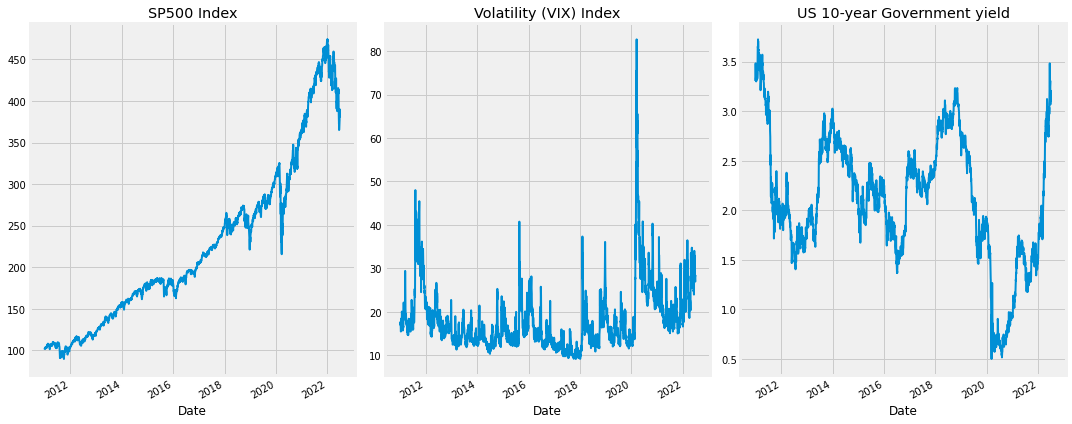

In [5]:
# Plot SP500 Index, VIX Index and US 10Y Government yield
%matplotlib inline
fig, ax = plt.subplots(1,3, figsize=(15,6))
df['Adj Close'].plot(title='SP500 Index', ax=ax[0], grid=True, linewidth=2)
df['VIX'].plot(title='Volatility (VIX) Index', ax=ax[1], grid=True, linewidth=2)
df['10Y_yield'].plot(title='US 10-year Government yield', ax=ax[2], grid=True, linewidth=2)
plt.tight_layout()

### Feature creation

**Features (also called predictors) are the independent variables which are used to determine the value of the target variable (the dependent variable we aim to predict)**. Now that we have a fair understanding of the behavior of the SP500 Index, VIX Index as well as 10-Year US yield over the past 10 years, **we start building lagged features based on these three underlying financial quantities**. In particular, we will take as additional new features the 2, 3, 5 (1 week), 10 (2 weeks), 21 (1 month), 93 (3 months), 181 (6 months) and 252 (1 year) daily lagged values of:
- **SP500 Index**: Return, Momentum, Exponential Moving Average (EMA), Volatility, Average True Range (ATR), and Upper / Lower Bollinger bands
- **VIX Index**: Value change, Momentum, Exponential Moving Average (EMA), Volatility and Upper / Lower Bollinger bands
- **10-Year US Treasury Index**: Change, Momentum, Exponential Moving Average (EMA), Volatility and Upper / Lower Bollinger bands

If features like return, momentum or EMA no longer need an introduction, **VIX, ATR and Bollinger bands also directly relate to SP500 volatility**:
- VIX is a measure derived from options prices and reflects the current implied volatility that the market expects in one-month time, reflected in a strip of S&P 500 Index options.
- ATR is the average of true ranges over a specified period. ATR measures volatility, taking into account any gaps in the price movement. An expanding ATR indicates increased volatility in the market.
- Bollinger bands indicate periods of quiet and explosive trading.

In [6]:
# Function to calculate the Average True Range
def ATR(dataframe, period):
    'function to calculate True Range and Average True Range'
    df = dataframe.copy()
    df['H-L']  = abs(df['High']-df['Low'])
    df['H-PC'] = abs(df['High']-df['Close'].shift(1))
    df['L-PC'] = abs(df['Low']-df['Close'].shift(1))
    df['TR']   = df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR']  = df['TR'].rolling(period).mean()
    df = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df['ATR']

# Creation of model features
def create_features(df):
    # Calculate daily log returns
    df['Return'] = np.log(df['Adj Close']).diff()
    # Create time-lagged features for SP500 Index
    for r in [2,3,5,10,21,93,181,252]:   # r: number of lagged days
        df['Return_'+str(r)+'d'] = df['Return'].rolling(r).sum()
        df['Momentum_'+str(r)+'d'] = df['Adj Close']-df['Adj Close'].shift(periods=r)
        df['EMA_'+str(r)+'d'] = df['Adj Close'].ewm(r, adjust=False).mean()
        df['Volatility_'+str(r)+'d'] = df.Return.rolling(r).std()
        df['ATR_'+str(r)+'d'] = ATR(df,r)
        # Bollinger bands
        multiplier = 2
        df['UpperBand_'+str(r)+'d'] = df['Adj Close'].rolling(r).mean() + df['Adj Close'].rolling(r).std() * multiplier
        df['LowerBand_'+str(r)+'d'] = df['Adj Close'].rolling(r).mean() - df['Adj Close'].rolling(r).std() * multiplier
    
    # Create time-lagged features for VIX Index
    for r in [2,3,5,10,21,93,181,252]:   # r: number of lagged days
        df['VIX_Change'] = np.log(df['VIX']).diff()
        df['VIX_Change_'+str(r)+'d'] = df['VIX_Change'].rolling(r).sum()
        df['VIX_Momentum_'+str(r)+'d'] = df['VIX']-df['VIX'].shift(periods=r)
        df['VIX_EMA_'+str(r)+'d'] = df['VIX'].ewm(r, adjust=False).mean()
        df['VIX_Volatility_'+str(r)+'d'] = df['VIX_Change'].rolling(r).std()
        # Bollinger bands
        multiplier = 2
        df['VIX_UpperBand_'+str(r)+'d'] = df['VIX'].rolling(r).mean() + df['VIX'].rolling(r).std() * multiplier
        df['VIX_LowerBand_'+str(r)+'d'] = df['VIX'].rolling(r).mean() - df['VIX'].rolling(r).std() * multiplier
    
    # Create time-lagged features for US 10Y yield 
    for r in [2,3,5,10,21,93,181,252]:   # r: number of lagged days
        df['10Y_Change'] = np.log(df['10Y_yield']).diff()
        df['10Y_Change_'+str(r)+'d'] = df['10Y_Change'].rolling(r).sum()
        df['10Y_Momentum_'+str(r)+'d'] = df['10Y_yield']-df['10Y_yield'].shift(periods=r)
        df['10Y_EMA_'+str(r)+'d'] = df['10Y_yield'].ewm(r, adjust=False).mean()
        df['10Y_Volatility_'+str(r)+'d'] = df['10Y_Change'].rolling(r).std()
        # Bollinger bands
        multiplier = 2
        df['10Y_UpperBand_'+str(r)+'d'] = df['10Y_yield'].rolling(r).mean() + df['10Y_yield'].rolling(r).std() * multiplier
        df['10Y_LowerBand_'+str(r)+'d'] = df['10Y_yield'].rolling(r).mean() - df['10Y_yield'].rolling(r).std() * multiplier       
    # Drop NaN values
    df.dropna(inplace=True)
    return df

We remove all NA values resulting from the creation of lagged features from the dataframe, in order to end up with 10 years of complete daily data for each feature. At this stage, our dataframe has 2,639 daily values and 163 different eligible features for our prediction model.

In [7]:
create_features(df)
print(df.shape)
df

(2639, 163)


Open        High         Low       Close   Adj Close  \
Date                                                                     
2011-12-30  126.019997  126.330002  125.500000  125.500000  102.860191   
2012-01-03  127.760002  128.380005  127.430000  127.500000  104.499428   
2012-01-04  127.199997  127.809998  126.709999  127.699997  104.663338   
2012-01-05  127.010002  128.229996  126.430000  128.039993  104.942017   
2012-01-06  128.199997  128.220001  127.290001  127.709999  104.671524   
...                ...         ...         ...         ...         ...   
2022-06-23  376.640015  378.829987  372.890015  378.059998  378.059998   
2022-06-24  381.399994  390.089996  381.369995  390.079987  390.079987   
2022-06-27  391.049988  391.359985  387.440002  388.589996  388.589996   
2022-06-28  390.230011  393.160004  380.529999  380.649994  380.649994   
2022-06-29  381.230011  382.269989  378.420013  380.339996  380.339996   

               Volume        VIX  10Y_yield    Return  Return_2d  ...  \
Date                                                              ...   
2011-12-30   95599000  23.400000      1.871 -0.004928   0.005353  ...   
2012-01-03  193697900  22.969999      1.960  0.015811   0.010883  ...   
2012-01-04  127186500  22.219999      1.995  0.001567   0.017378  ...   
2012-01-05  173895000  21.480000      1.993  0.002659   0.004226  ...   
2012-01-06  148050000  20.629999      1.961 -0.002581   0.000078  ...   
...               ...        ...        ...       ...        ...  ...   
2022-06-23   79292100  29.049999      3.068  0.009755   0.007940  ...   
2022-06-24   98050300  27.230000      3.125  0.031299   0.041054  ...   
2022-06-27   66009600  26.950001      3.194 -0.003827   0.027472  ...   
2022-06-28   86548900  28.360001      3.206 -0.020644  -0.024472  ...   
2022-06-29   65676000  28.160000      3.093 -0.000815  -0.021459  ...   

            10Y_EMA_181d  10Y_Volatility_181d  10Y_UpperBand_181d  \
Date                                                                
2011-12-30      2.725487             0.030983            3.548036   
2012-01-03      2.721281             0.031198            3.532010   
2012-01-04      2.717290             0.031205            3.517449   
2012-01-05      2.713311             0.031199            3.503604   
2012-01-06      2.709177             0.031214            3.490025   
...                  ...                  ...                 ...   
2022-06-23      1.924885             0.032110            3.315708   
2022-06-24      1.931479             0.032060            3.330720   
2022-06-27      1.938416             0.032083            3.347095   
2022-06-28      1.945381             0.032023            3.363691   
2022-06-29      1.951687             0.032132            3.377462   

            10Y_LowerBand_181d  10Y_Change_252d  10Y_Momentum_252d  \
Date                                                                 
2011-12-30            1.432660        -0.568963             -1.434   
2012-01-03            1.431835        -0.533625             -1.382   
2012-01-04            1.430761        -0.517122             -1.351   
2012-01-05            1.429380        -0.558253             -1.490   
2012-01-06            1.427544        -0.555894             -1.458   
...                        ...              ...                ...   
2022-06-23            0.907839         0.724265              1.581   
2022-06-24            0.910462         0.742674              1.638   
2022-06-27            0.912540         0.732092              1.658   
2022-06-28            0.914011         0.774334              1.728   
2022-06-29            0.916682         0.737099              1.613   

            10Y_EMA_252d  10Y_Volatility_252d  10Y_UpperBand_252d  \
Date                                                                
2011-12-30      2.856539             0.027695            4.012655   
2012-01-03      2.852995             0.027852            4.009057   
2012-01-04      2.84

**By predicting the class of the future RV-IV spread, we attempt to get a better understanding of the future volatility to come**. As mentioned above, the IV tends to be above the RV on the long run, which means that the market usually over-estimates the volatility to come. **What we are interested here is to predict situations where the RV-IV spread is positive; in other terms, when RV is above IV**. This latter situation describes **a situation where volatility is greater than what the market anticipate, which therefore indicates that the market enters into a period of uncertainty and bear market territory**. 

The figure below illustrates the SP500 RV-IV spread since 2012. As we can see, the IV is consistently above the RV, to some exception when both volatilities increase, in terms of market stress. The plot illustrates the impact of information on volatility, as events like Brexit, Trump election and of course Covid simply drove the volatility up. We also note that in times of market stress, realized volatility tends to be higher than implied volatility.

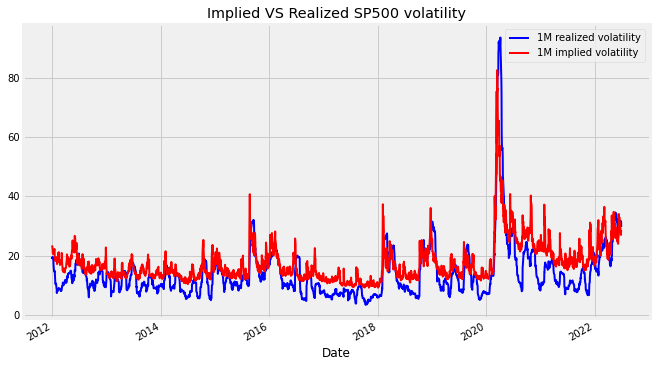

In [8]:
# Plot implied VS realized 1M SP500 (annualized) volatility 
realized = df['Volatility_21d']*100*(252)**0.5
implied = df['VIX']
plt.figure(figsize=(10,6))
realized.plot(color='b', grid=True, linewidth=2, label='1M realized volatility')
implied.plot(color='r', grid=True, linewidth=2, label='1M implied volatility')
plt.legend()
plt.title('Implied VS Realized SP500 volatility');

### Label definition

We create a new variable, called 'Difference', which measures the SP500 RV-IV spread.

**Label (also called target) variable is the dependent variable that we aim to predict**. Here, the target variable is whether 'Difference' will close positive or negative on the next trading day, e.g. if RV will close above or below IV. We assign to the target variable a value of +1 for when tomorrow's RV is greater than tomorrow' IV, and 0 otherwise. The target can be described as :

$$
y_t = \left\{
    \begin{array}{ll}
        1 & \mbox{if } RV_{t+1}>IV_{t+1} \equiv \text{RV-IV}_{t+1}>0\\
        0 & \mbox{otherwise}
    \end{array}
\right.
$$

where $RV_{t+1}$ is the 1-day forward SP500 realized volatility (derived from 1 month observations), $IV_{t+1}$ is the 1-day forward SP500 implied volatility (estimate of the volatility in 1 month time), and $\text{RV-IV}_{t+1}$ the difference between the two.

In [9]:
# Classification label: days where realized volatility - implied volatility > 0 are classified as 1, 0 otherwise
df['Difference'] = realized - implied
df['Label'] = np.where(df['Difference'].shift(-1) > 0, 1, 0)
df = df.dropna()
# Remove the last row in the dataframe for the final prediction
df = df[:-1]
print(f'Data shape: {df.shape}')
print(pd.Series(df['Label']).value_counts())

Data shape: (2638, 165)
0    2227
1     411
Name: Label, dtype: int64


On a total of 2,638 days (as we remove the last row from Thursday 30 June 2022 for the final prediction), the realized volatility was above the implied volatility for 411 days, e.g. for 16% of the time, which indicates that **our dataset is imbalanced. As a consequence, accuracy results will be biased** (until we address the problem from section 3 onwards), **as it becomes easy to obtain a high accuracy by simply classifying all observations as the majority class**.

Finally, and prior jumping to the importance of features below, we check that the RV-IV spread is stationary. Stationarity is important in time series analysis because in its absence, a model describing the data will vary in accuracy at different time points. As such, **stationarity is required for sample statistics such as means, variances and correlations to accurately describe the data at all points of interest**. Despite stationarity may sometimes be of lower importance for machine learning models, it is always a good thing to check.

ADF statistic: -7.268129
ADF p-value: 0.000000
Critical values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


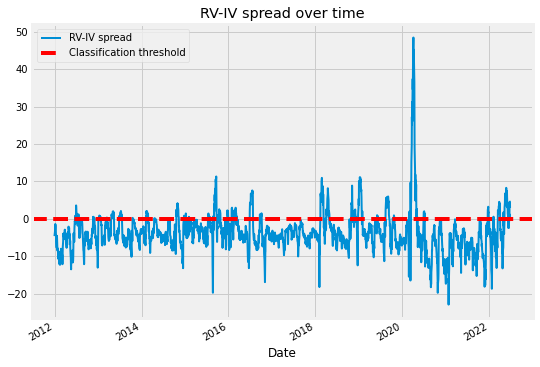

In [10]:
# Check the difference between implied and realized volatility is stationary
ADF_vol = adfuller(df['Difference'])
print('ADF statistic: %f' % ADF_vol[0])
print('ADF p-value: %f' % ADF_vol[1])
print('Critical values:')
for key, value in ADF_vol[4].items():
    print('\t%s: %.3f' % (key, value))
# Plot difference
plt.figure(figsize=(8,6))
df['Difference'].plot(title='RV-IV spread over time', label='RV-IV spread', grid=True, linewidth=2);
plt.axhline(y=0, color='r', linestyle='--', label='Classification threshold');
plt.legend();

The AD Fuller test indicates that the SP500 RV-IV spread is a stationary time series. As confirmed from the previous plot, the SP500 RV-IV spread is mostly negative, to some exceptions.

### Train-Test split

We now explicitly define our set of features $X$ and label $Y$. We exclude from the features' list the 'Open', 'High', 'Low', 'Close', 'Volume', 'Label' and 'Difference' variables, are those are already reflected in other variables like 'Adj Close' price, or ATR features. For the same reasons, we also exclude the 'VIX' and 'Volatility_21d', as these are the two quantities of interest that were used to derive the 'Difference' variable on which our target is built. As a result, **we have a total of 156 features to predict our target variable, for a total of 2,638 daily observations.**.

**All the features should have a similar scale for every of the 156 features to be equally represented when estimating the feature importance and building the model. For this reason, we apply the MinMaxScaler to the entire feature set**.

$$X_{scaled} = \frac{X-X_{min}}{X_{max}-X_{min}}$$

In [11]:
# Define Y
Y = df['Label']
# Prepare X and Y
data = df.copy()
X = data.drop(['Open','High','Low','Close','Volume','Label','Difference','Volatility_21d','VIX'], axis=1)
labels = X.columns
# Transfor feature matrix
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=labels)
print(f'Number of daily prices: {X.shape[0]} | Number of features: {X.shape[1]}')

Number of daily prices: 2638 | Number of features: 156


We split the dataset into two parts: 80% of the data is kept for model training purposes while the remaining 20% are kept for test purposes, e.g. to evaluate the model performance on unseen data. When dealing with time series, the set-up 'shuffle=False' is crucial as it allows to avoid look-ahead bias.

In [12]:
# Split the datasets into training and testing data.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)
# Output the train and test data size
print(f'Train and Test Size {len(X_train)}, {len(X_test)}')

Train and Test Size 2110, 528


## Feature importance

When inputting features into a model, **the goal is to feed the model with features that are relevant for predicting a class. Including irrelevant features poses the problem of unnecessary noise in the data, resulting in lower model accuracy**.

In this section, we estimate the importance of the 156 proposed features based on 3 feature importance algorithms:
- Boruta
- Decision Tree Classifier (DTC)
- Self Organizing Maps (SOM)

Boruta is an all relevant feature selection method, thus the selected features are all relevant to the outcome and may be correlated. Therefore, **we start the feature selection process with Boruta. We then apply to the set of Boruta approved features the DTC and SOM, and cross their respective results in order to come up with a set of final features**. We propose three sets of features:
- First choice: features resulting from Boruta algorithm.
- Choice A: features resulting from Boruta algorithm are passed through the DTC and SOM. Choice A features only consists of DTC and SOM 20 most important features with a correlation below 75%.
- Choice B: Choice B simply lists Boruta features with a correlation below 75%.

**The choice of the feature set is based on the ROC curve, as it indicates which model is best capable to distinguish betweeen our two prediction classes**. The feature set with the best ROC curve score (AUC) for the best number of features will be selected as input for our neural network model.

As we yet work with an imbalanced dataset, accuracy scores are biased as explain in section 1.3 above and detailed in section 3 below. As a consequence, **our key evaluation metric in section 2 will be the ROC curve and not the accuracy score**.

### Boruta

**Boruta algorithm is a wrapper built around the random forest classification algorithm - relatively quick and able to run without tuning of parameters, which gives a numerical estimate of the feature importance**. The importance measure of an attribute is obtained as the loss of accuracy in classification caused by the random permutation of attribute values between objects.

Due to the fact that the number of random forest runs during Boruta is limited by the maximum of iterations, the calculation can be forced to stop prematurely, when there are still attributes which are judged neither to be confirmed nor rejected, and thus finally marked as tentative.

We initialize the Boruta algorithm with a Random Forest of maximum depth of 5.

In [13]:
# Class weight function
def cwts(df):
    c0, c1 = np.bincount(df['Label'])
    w0=(1/c0)*(len(df))/2 
    w1=(1/c1)*(len(df))/2 
    return {0: w0, 1: w1}

# Initiate Random Forest model
rf_all_features = RandomForestClassifier(n_jobs=-1, 
                                class_weight=cwts(df), 
                                random_state=42, 
                                max_depth=5)
rf_all_features.fit(X_train, y_train)
predictions = rf_all_features.predict(X_test)
# Print classification report
print(classification_report(y_test, predictions))
print(f'Train Accuracy:  {accuracy_score(y_train, rf_all_features.predict(X_train)):.2%}')
print(f'Test Accuracy:  {accuracy_score(y_test, rf_all_features.predict(X_test)):.2%}')

              precision    recall  f1-score   support

           0       0.98      0.82      0.89       473
           1       0.36      0.84      0.50        55

    accuracy                           0.83       528
   macro avg       0.67      0.83      0.70       528
weighted avg       0.91      0.83      0.85       528

Train Accuracy:  92.23%
Test Accuracy:  82.58%


The random forest algorithm performs well - but **on an imbalanced dataset!** In sample accuracy totals to 92% while out-of-sample accuracy sums up to 83%. **We now apply the Boruta selection algorithm to our set of 156 features**.

In [14]:
# Initialise Boruta
boruta_selector = BorutaPy(rf_all_features, n_estimators='auto', verbose=2, random_state=1)
boruta_selector.fit(np.array(X_train), np.array(y_train))
# Print support and ranking for each feature
print("\n------Support and Ranking for each feature------\n")
for i in range(len(boruta_selector.support_)):
    if boruta_selector.support_[i]:
        print("Passes the test: ", X_train.columns[i],
              " - Ranking: ", boruta_selector.ranking_[i], "✔️")
    else:
        print("Doesn't pass the test: ",
              X_train.columns[i], " - Ranking: ", boruta_selector.ranking_[i], "❌")

# Features selected by Boruta
X_train_filtered = boruta_selector.transform(np.array(X_train))
print("\n------Selected Features------\n")
boruta_accepted = X_train.columns[boruta_selector.support_].to_list()
boruta_rejected = X_train.columns[boruta_selector.support_weak_].to_list()
print(boruta_accepted)
# Train the model
rf_all_features.fit(X_train_filtered, y_train)
# Compute predictions and RMSE
predictions_boruta = rf_all_features.predict(X_train_filtered)
boruta_results = pd.DataFrame({'pred': predictions_boruta, 'observed': y_train})

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	156
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	156
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	156
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	156
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	156
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	156
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	156
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	126
Tentative: 	30
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	126
Tentative: 	23
Rejected: 	7
Iteration: 	10 / 100
Confirmed: 	126
Tentative: 	23
Rejected: 	7
Iteration: 	11 / 100
Confirmed: 	126
Tentative: 	23
Rejected: 	7
Iteration: 	12 / 100
Confirmed: 	130
Tentative: 	19
Rejected: 	7
Iteration: 	13 / 100
Confirmed: 	130
Tentative: 	19
Rejected: 	7
Iteration: 	14 / 100
Confirmed: 	130
Tentative: 	19
Rejected: 	7
Iteration: 	15 / 100
Confirmed: 	130
Tentative: 	19
Rejected: 	7
Iteration: 	16 / 100
Confirmed: 	132
Tent


------RMSE------
 0.269


Out of the 156 features, the Boruta method resulted in the selection of 138 features.

In [15]:
# Apply feature selector transform to make sure all same features are selected
X_test_filtered = boruta_selector.transform(X_test.values)
# Check the shape
print(f'Shape of feature set X_test is: {X_test_filtered.shape}')

Shape of feature set X_test is: (528, 138)


We now check whether selecting features further would help, in particular Decision Tree Classifier (DTC) and Self-Organizing Maps (SOM).

### Decision Tree Classifier

CART stands for Classification and Regression Trees. The CART algorithm creates a binary tree, which means that each node has exactly two outgoing edges, in order to find the best numerical or categorical feature to split using an appropriate impurity criterion. 
- For classification, Gini impurity or entropy criterion can be used
- For regression, CART introduces variance reduction using least squares (mean square error for instance)

**The main advantage of CART in our situation is the CART algorithm will itself identify the most significant variables and eliminate the non-significant ones**. More particularly, feature importance is calculated as the decrease in node impurity weighted by the probability of reaching that node. The node probability can be calculated by the number of samples that reach the node, divided by the total number of samples. The higher the value, the more important the feature.

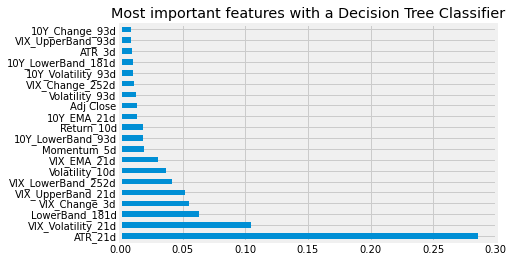

In [16]:
%matplotlib inline
# Decision Tree Classifier for feature importance
model = DecisionTreeClassifier(random_state=0)
model.fit(X_train[boruta_accepted], y_train)
# #plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=boruta_accepted)
most_dtr = feat_importances.nlargest(20).index.values
feat_importances.nlargest(20).plot(kind='barh')
plt.title('Most important features with a Decision Tree Classifier')
plt.show()

Naturally, the ATR features based on the past 21 observations carries the most importance, as the ATR is closely related to the realized volatility, upon which our label is derived from. **VIX and US 10Y Government yield related features also play a role in predicting the SP500 RV-IV spread**.

### Self-Organizing Map

A self-organizing map (SOM) is an unsupervised machine learning technique used to produce a low-dimensional (typically two-dimensional) representation of a higher dimensional data set while preserving the topological structure of the data. **SOM is a topology-preserving feature map that represents the distribution of features in the feature space**. In SOM similar feature vectors are mapped to adjacent map elements. During the training phase, the map is fed with a large number of unclassified feature vectors. More exctaly, **a SOM is a type of artificial neural network but is trained using competitive learning rather than the error-correction learning** (e.g., backpropagation with gradient descent) used by other artificial neural networks, and is used for feature selection.

The figure below illustrates the block diagram of the feature selection process with a SOM:
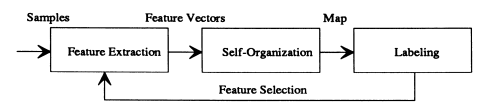

**The SOM is a practical method to find a set of features**. It is straightforward and easy to implement, and the need of preclassified samples is minimized. SOM is used in a feature selection as follows: 
1. Take $n$ features. 
2. Train the map with a large set of these features. Label the map with a set of pre-classified samples. 
    - If the classes in the labeled map overlap add a new feature or replace a feature with a new one. 
    - If the feature does not improve the separability of the classes, the feature will be replaced. 
3. Train the map again with a set of new features and label the map. 
4. Repeat this procedure until you have a set of features that can reach the desired classification rate. 

*NOTE: The feature importance for SOM is obtained from the popsom package - coming as .txt attached to this notebook*

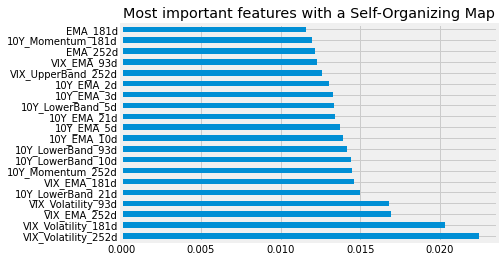

In [17]:
%matplotlib inline
# SOM features selection based on a 10x10 SOM
m = popsom.map(xdim=10,ydim=10,train=1000,norm=False)
m.fit(X_train[boruta_accepted],y_train)
features_imp = m.significance(False,False)
feat_importances = pd.Series(features_imp, index=boruta_accepted)
most_som = feat_importances.nlargest(20).index.values
feat_importances.nlargest(20).plot(kind='barh')
plt.title('Most important features with a Self-Organizing Map')
plt.show()

Interestingly, the SOM most important features seem to have a longer lag than the most important features resulting from DTC. We now plot the features in a SOM to see how the 138 Boruta features organize together.

In [18]:
# SOM input
som_data = X[boruta_accepted].describe().T
som_labels=X[boruta_accepted].columns.T
som_data = som_data.drop(['count','min','max'],axis=1)
som_values = som_data.values
# Initialize a 10x10 SOM
som = MiniSom(10, 10, 5, learning_rate=0.5, sigma=5, random_seed=42)
# Initialize with randon weights
som.random_weights_init(som_values)
# Trains SOM with 10000 iterations
som.train_batch(som_values,10000, verbose=True)

 [  1175 / 10000 ]  12% - 0:00:01 left 

 [  2279 / 10000 ]  23% - 0:00:01 left 

 [  3275 / 10000 ]  33% - 0:00:01 left 

 [  4316 / 10000 ]  43% - 0:00:00 left 

 [  5279 / 10000 ]  53% - 0:00:00 left 

 [  6272 / 10000 ]  63% - 0:00:00 left 

 [  6970 / 10000 ]  70% - 0:00:00 left 

 [  8040 / 10000 ]  80% - 0:00:00 left 

 [  9208 / 10000 ]  92% - 0:00:00 left 

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.0398636000364013


The SOM is a map made of Best Matching Units (BMU). **Each feature is attributed to a BMU, and the pairs of neighbouring data waim to be projected on the same or neighbouring unit**. The quantisation error is an average distance between each feature and its BMU. 
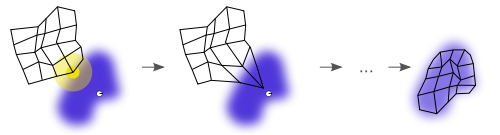
Important to note,
- when comparing two SOM, the SOM with the lowest quantisation error fits the data more accurately on average
- quantisation error only measures relationship between units and items mapped to those units, not how units preserve neighbourhood of the data

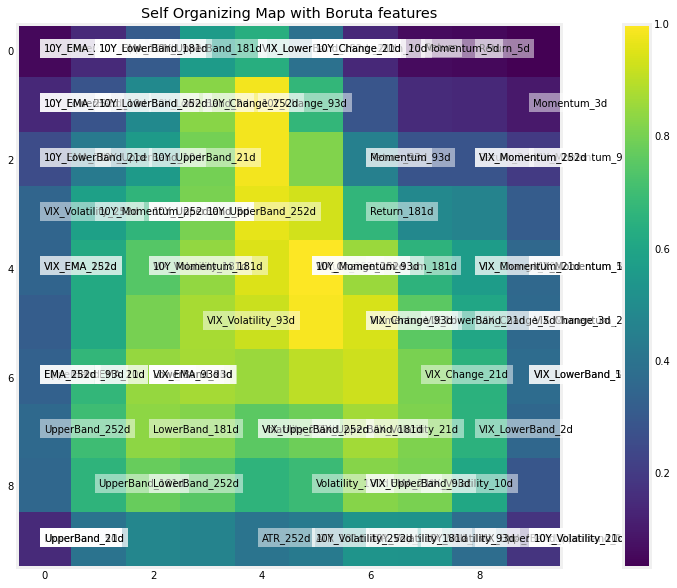

In [20]:
# Plot SOM
plt.figure(figsize=(20, 10))
for ix in range(len(som_values)):
    winner = som.winner(som_values[ix])
    plt.text(winner[0], winner[1], som_labels[ix], bbox=dict(facecolor='white', alpha=0.5, lw=0)) 
plt.imshow(som.distance_map())
plt.colorbar()
plt.grid(False)
plt.title('Self Organizing Map with Boruta features');

The SOM indicates that some features are correlated, as they sit on the same BMU, or very close neighborhood. All 138 Boruta features have a good coverage on the SOM. Although we can distinguish some areas of the SOM related  to some type of features, or for a given time lag, **plotting a SOM doesn't come with much readability when we have many features**.

### Feature selection

Until now, we saw three different approaches to decide for the importance on each feature in label prediction: Boruta, DTC and SOM. As we saw, Boruta is very helpful inasmuch as it selects all relevant features, but this comes with the disadvantage that it selects all relevant features, and some features may be correlated. **In this subsection, the idea is to benefit from all the DTC and SOM independent methods on top of Boruta, and combine them into one final 'smarter' set of features**. To do so:
1. We merge without duplicates the **20 most important features from the DTC and SOM** methods.
2. We **remove all features** obtained in 1. **which have a correlation higher than 75%**.
3. We plot the final set of features obtained in 2. on a Self-Organizing Map to ensure they do not overlap between each other. As the number of features is now reduced, the SOM should now come with readability.
4. We **plot the ROC curve for the different Random Forest Classifier models obtained with the different feature sets** and select the model which distinguish the best between the two classes.

#### Choice A

In order to get Choice A features, we take the unique features between SOM and DTC most important 20 feature sets which have a correlation below 75%.

Final number of features selected: 14


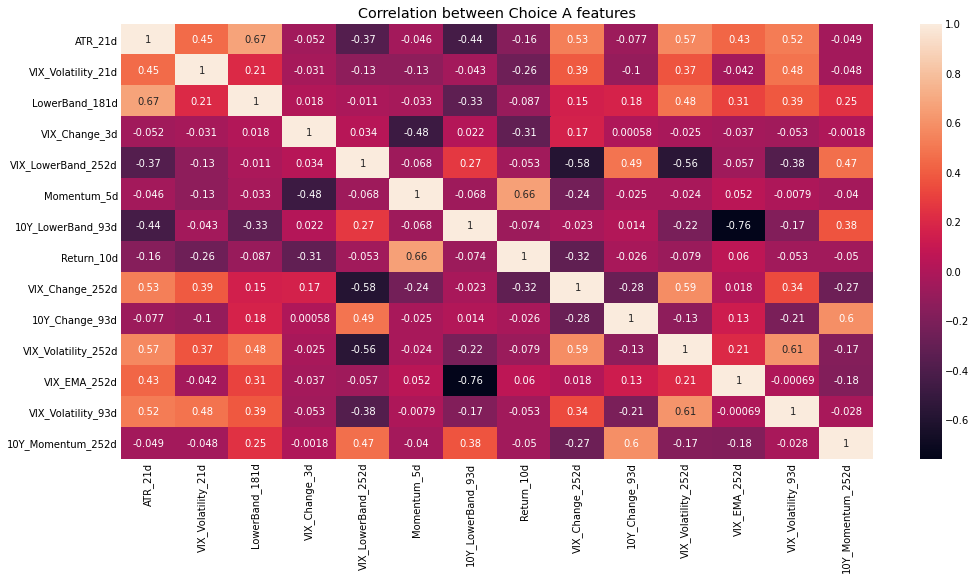

In [21]:
# Union of uniques features from DTC and SOM
selected_features = list(most_dtr)
selected_features.extend(x for x in most_som if x not in selected_features)
# Remove features with correlation above 75%
X_A = X[selected_features]
corrmat = X_A.corr()
upper_tri = corrmat.where(np.triu(np.ones(corrmat.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.75)]
# Plot correlation table for final list of features
X_final = X_A.drop(to_drop, axis=1)
final_features = X_final.columns
print(f'Final number of features selected: {len(final_features)}')
corrMatrix=X_final.corr()
plt.figure(figsize = (15,8))
sn.heatmap(corrMatrix, annot=True)
plt.title('Correlation between Choice A features')
plt.show()

In [22]:
# Make predictions with our new dataset of features
forest = RandomForestClassifier(n_jobs=-1, 
                                class_weight=cwts(df), 
                                random_state=42, 
                                max_depth=5)
forest.fit(X_train[final_features], y_train)
final_predictions = forest.predict(X_test[final_features])
# print classification report
print(classification_report(y_test, final_predictions))

              precision    recall  f1-score   support

           0       0.95      0.55      0.70       473
           1       0.16      0.73      0.26        55

    accuracy                           0.57       528
   macro avg       0.55      0.64      0.48       528
weighted avg       0.86      0.57      0.65       528



As we see from the classification report, **the model struggles to predict class 1 with a set of 14 features**, which is a typical issue arising from an imbalanced dataset.

We now plot the final set of 14 features on a SOM. **At this stage, we expect the 14 features to be quite different in nature, and therefore most of them to be on a different BMU**.

 [   970 / 10000 ]  10% - 0:00:01 left 

 [  2072 / 10000 ]  21% - 0:00:01 left 

 [  3142 / 10000 ]  31% - 0:00:01 left 

 [  4239 / 10000 ]  42% - 0:00:01 left 

 [  5291 / 10000 ]  53% - 0:00:00 left 

 [  6326 / 10000 ]  63% - 0:00:00 left 

 [  7399 / 10000 ]  74% - 0:00:00 left 

 [  8365 / 10000 ]  84% - 0:00:00 left 

 [  9169 / 10000 ]  92% - 0:00:00 left 

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.0339675827639366


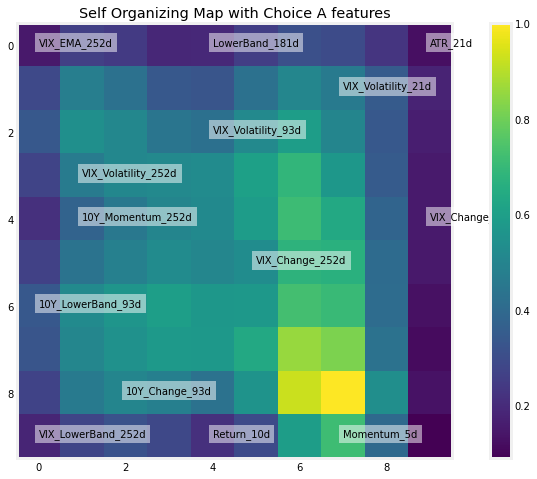

In [23]:
# SOM input
som_data = X[final_features].describe().T
som_labels=X[final_features].columns.T
som_data = som_data.drop(['count','min','max'],axis=1)
som_values = som_data.values
# Initialize a 10x10 SOM
som = MiniSom(10, 10, 5, learning_rate=0.5, sigma=5, random_seed=42)
# Initialize with randon weights
som.random_weights_init(som_values)
# Trains SOM with 10000 iterations
som.train_batch(som_values,10000, verbose=True)
# Plot SOM
plt.figure(figsize=(12, 8))
for ix in range(len(som_values)):
    winner = som.winner(som_values[ix])
    plt.text(winner[0], winner[1], som_labels[ix], bbox=dict(facecolor='white', alpha=0.5, lw=0)) 
plt.imshow(som.distance_map())
plt.colorbar()
plt.grid(False)
plt.title('Self Organizing Map with Choice A features');

As we expected, **each of the 14 Choice A features is now on a different BMU**. We can see that our 14 features are well represented on the SOM, as they broadly cover the entire map without being cornered on some part.

#### Choice B

In order to get Choice B features, we take the Boruta features which have a correlation below 75%.

Final number of features selected: 26


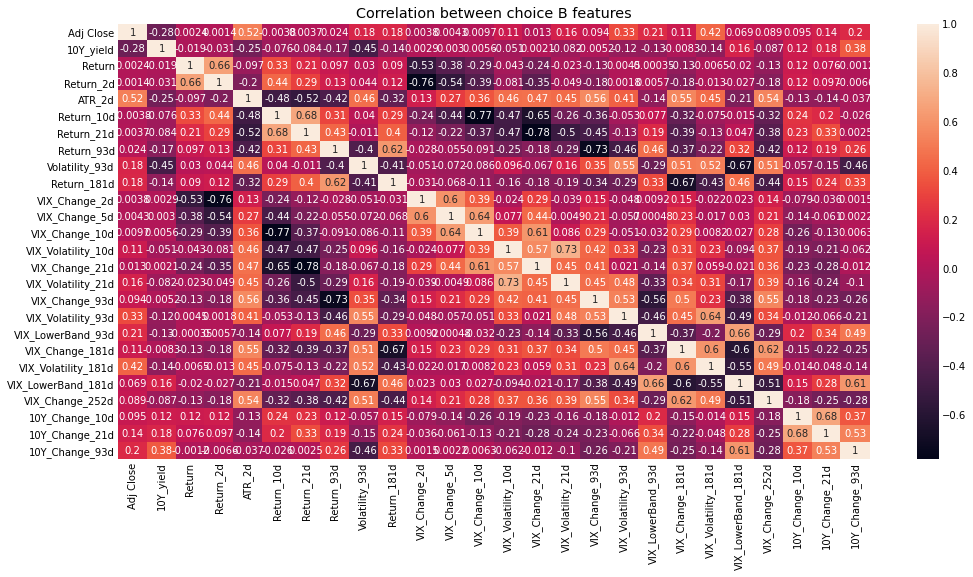

In [24]:
# Remove features with correlation above 75%
X_B = X[boruta_accepted]
corrmat_B = X_B.corr()
upper_tri_B = corrmat_B.where(np.triu(np.ones(corrmat_B.shape),k=1).astype(np.bool))
to_drop_B = [column for column in upper_tri_B.columns if any(upper_tri_B[column] > 0.75)]
# Plot correlation table for final list of features
X_final_B = X_B.drop(to_drop_B, axis=1)
final_features_B = X_final_B.columns
print(f'Final number of features selected: {len(final_features_B)}')
corrMatrix_B = X_final_B.corr()
plt.figure(figsize = (15,8))
sn.heatmap(corrMatrix_B, annot=True)
plt.title('Correlation between choice B features')
plt.show()

In [27]:
# Make predictions with our new dataset of features
forest_B = RandomForestClassifier(n_jobs=-1, 
                                class_weight=cwts(df), 
                                random_state=42, 
                                max_depth=5)
forest_B.fit(X_train[final_features_B], y_train)
final_predictions_B = forest_B.predict(X_test[final_features_B])
# print classification report
print(classification_report(y_test, final_predictions_B))

              precision    recall  f1-score   support

           0       0.96      0.69      0.81       473
           1       0.23      0.78      0.35        55

    accuracy                           0.70       528
   macro avg       0.60      0.74      0.58       528
weighted avg       0.89      0.70      0.76       528



Choice B model succeeds better to predict both classes with the filtered set of 26 features than Choice A model.

We now plot the final set of 26 features on a SOM. **As these 26 features have a correlation below 75%, we also expect most of them to be on a different BMU**.

 [  1072 / 10000 ]  11% - 0:00:01 left 

 [  2199 / 10000 ]  22% - 0:00:01 left 

 [  3301 / 10000 ]  33% - 0:00:01 left 

 [  4395 / 10000 ]  44% - 0:00:00 left 

 [  5485 / 10000 ]  55% - 0:00:00 left 

 [  6487 / 10000 ]  65% - 0:00:00 left 

 [  7502 / 10000 ]  75% - 0:00:00 left 

 [  8564 / 10000 ]  86% - 0:00:00 left 

 [  9682 / 10000 ]  97% - 0:00:00 left 

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.03283681800909166


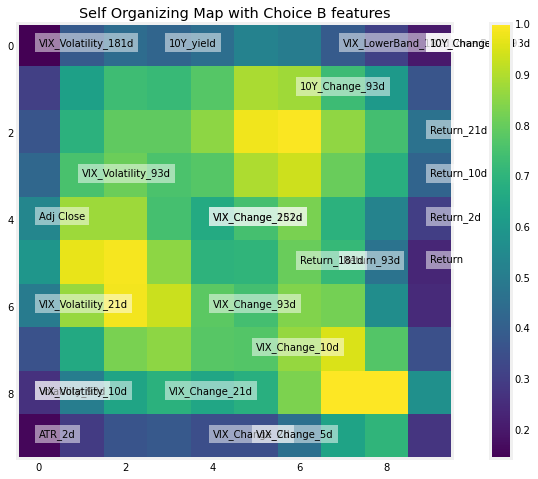

In [28]:
# SOM input
som_data = X[final_features_B].describe().T
som_labels = X[final_features_B].columns.T
som_data = som_data.drop(['count','min','max'],axis=1)
som_values = som_data.values
# Initialize a 10x10 SOM
som = MiniSom(10, 10, 5, learning_rate=0.5, sigma=5, random_seed=42)
# Initialize with randon weights
som.random_weights_init(som_values)
# Trains SOM with 10000 iterations
som.train_batch(som_values,10000, verbose=True)
# Plot SOM
plt.figure(figsize=(12, 8))
for ix in range(len(som_values)):
    winner = som.winner(som_values[ix])
    plt.text(winner[0], winner[1], som_labels[ix], bbox=dict(facecolor='white', alpha=0.5, lw=0)) 
plt.imshow(som.distance_map())
plt.colorbar()
plt.grid(False)
plt.title('Self Organizing Map with Choice B features');

As we expected, **each of Choice B 26 features is now on a different BMU**. As above, we see that our 26 features are well represented on the SOM, as they broadly cover the entire map without being cornered on some part.

### ROC curve

The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various classification thresholds. **The ROC curve indicates the loss of information that each model has on top of illustrating how well each model distinguishes between the two classes we aim to predict**. The area under the ROC curve (AUC) is a measure of how well a model can distinguish between two classes. Therefore, we plot on the ROC curve a Random Forest Classifier with:
1. All features included (156)
2. Boruta relevant features included (138)
3. Choice A: final 14 features selected with Boruta, DTC, SOM and maximum correlation at 75%
4. Choice B: final 26 features selected with Boruta and maximum correlation at 75%

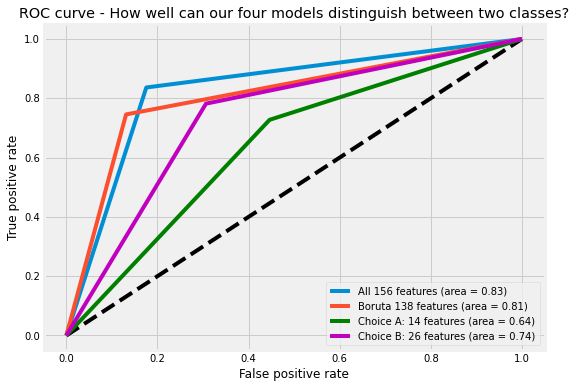

In [30]:
# Compare model performance before Boruta
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, predictions)
auc_rf = auc(fpr_rf, tpr_rf)
# Compare model performance after Boruta
boruta_predictions = rf_all_features.predict(X_test_filtered)
fpr_boruta, tpr_boruta, thresholds_boruta = roc_curve(y_test, boruta_predictions)
auc_boruta = auc(fpr_boruta, tpr_boruta)
# Compare model performance with final 13 features (Choice A)
final_predictions = forest.predict(X_test[final_features])
fpr_final, tpr_final, thresholds_final = roc_curve(y_test, final_predictions)
auc_final = auc(fpr_final, tpr_final)
# Compare model performance with final 13 features (Choice B)
B_predictions = forest_B.predict(X_test[final_features_B])
fpr_B, tpr_B, thresholds_B = roc_curve(y_test, B_predictions)
auc_B = auc(fpr_B, tpr_B)
# Plot the ROC curve
plt.figure(figsize= (8,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='All 156 features (area = {:.2f})'.format(auc_rf))
plt.plot(fpr_boruta, tpr_boruta, label='Boruta 138 features (area = {:.2f})'.format(auc_boruta))
plt.plot(fpr_final, tpr_final, label='Choice A: 14 features (area = {:.2f})'.format(auc_final), color = 'g')
plt.plot(fpr_B, tpr_B, label='Choice B: 26 features (area = {:.2f})'.format(auc_B), color = 'm')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - How well can our four models distinguish between two classes?')
plt.legend(loc='best')
plt.show()

As we see from the ROC curve, the Boruta choice of features without any additional feature selection method proves to better distinguish between two classes. Nevertheless, only 26 of the Boruta 138 features have a correlation below 75%. In other terms, 80% of Boruta selected features are highly correlated. As a result, we prefer Choice B features set to build predictions upon, considering that Choice A AUC score is significantly lower. 

From this point, **we use Choice B features as input dataset**.

## Address class imbalance

As mentioned above, classification predictive modeling involves predicting a class label for a given observation. An imbalanced classification problem is an example of a classification problem where the distribution of examples across the known classes is biased or skewed. **Until now, our dataset is imbalanced: as shown in section 1.3 above, we have 2,227 observations classified as 0 (Negative RV-IV spread), and only 411 classified as 1 (Positive RV-IV spread)**. 

**Imbalanced classifications pose a challenge for predictive modeling as most of the machine learning algorithms used for classification were designed around the assumption of an equal number of examples for each class. This results in models that have poor predictive performance, specifically for the minority class**. This is a problem because typically, the minority class is more important and therefore the problem is more sensitive to classification errors for the minority class than the majority class. In our problem, the accurate prediction of the minority class is what we are interested about!

The picture below depicts the situation quite well:
- When oversampling, we create additional points in the minority class in order to have a balanced dataset aligned on the majority class: it is achieved with the SMOTE algorithm.
- When undersampling, we remove points from the majority class in order to have a balanced dataset aligned on the minority class: it is achieved with the Near-Miss algorithm.

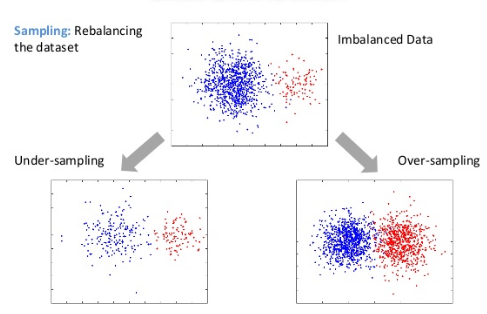

### Oversampling with SMOTE

SMOTE Algorithm oversamples the minority instances and makes it equal to majority class. Both categories have equal amount of records. More specifically, the minority class is increased to the total number of the majority class.

In [31]:
oversample = SMOTE(random_state = 2)
X_train_os, y_train_os = oversample.fit_resample(X_train[final_features_B], y_train)
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))
print("After OverSampling, counts of label '1': {}".format(sum(y_train_os == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_os == 0)))

Before OverSampling, counts of label '1': 356
Before OverSampling, counts of label '0': 1754 

After OverSampling, counts of label '1': 1754
After OverSampling, counts of label '0': 1754


The classification report indicates the accuracy after addressing class imbalance by oversampling.

In [40]:
rf_all_features.fit(X_train_os, y_train_os)
predictions_os = rf_all_features.predict(X_test[final_features_B])
# print classification report
print(classification_report(y_test, predictions_os))
print(f'Train Accuracy:  {accuracy_score(y_train_os, rf_all_features.predict(X_train_os)):.2%}')
print(f'Test Accuracy:  {accuracy_score(y_test, rf_all_features.predict(X_test[final_features_B])):.2%}')

              precision    recall  f1-score   support

           0       0.94      0.75      0.83       473
           1       0.21      0.56      0.30        55

    accuracy                           0.73       528
   macro avg       0.57      0.66      0.57       528
weighted avg       0.86      0.73      0.78       528

Train Accuracy:  87.83%
Test Accuracy:  73.11%


As a result of the SMOTE algorithm, we note that:
- The difference between the Train and Test accuracy increased from around 9 to 15
- The Train accuracy decreased from 92 to 88
- The Test accuracy decreased from 83 to 73

Nevertheless, 
- Train and Test accuracy remain high
- Overfitting is remains limited


In conclusion, **the SMOTE algorithm is a good candidate to address class imbalance in our problem**.

### Undersampling with NearMiss

NearMiss Algorithm undersamples the majority instances and makes it equal to minority class. Both categories have equal amount of records. More specifically, the majority class is decreased to the total number of the minority class.

In [34]:
undersample = NearMiss()
X_train_us, y_train_us = undersample.fit_resample(X_train[final_features_B], y_train)
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))
print("After OverSampling, counts of label '1': {}".format(sum(y_train_us == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_us == 0)))

Before OverSampling, counts of label '1': 356
Before OverSampling, counts of label '0': 1754 

After OverSampling, counts of label '1': 356
After OverSampling, counts of label '0': 356


The classification report indicates the accuracy after addressing class imbalance by undersampling.

In [42]:
rf_all_features.fit(X_train_us, y_train_us)
predictions_us = rf_all_features.predict(X_test[final_features_B])
# print classification report
print(classification_report(y_test, predictions_us))
print(f'Train Accuracy:  {accuracy_score(y_train_us, rf_all_features.predict(X_train_us)):.2%}')
print(f'Test Accuracy:  {accuracy_score(y_test, rf_all_features.predict(X_test[final_features_B])):.2%}')

              precision    recall  f1-score   support

           0       0.94      0.67      0.78       473
           1       0.18      0.64      0.28        55

    accuracy                           0.66       528
   macro avg       0.56      0.65      0.53       528
weighted avg       0.86      0.66      0.73       528

Train Accuracy:  77.95%
Test Accuracy:  66.48%


As a result of the Near Miss algorithm, we note that:
- The difference between the Train and Test accuracy increased from around 9 to 12
- The Train accuracy decreased from 92 to 78
- The Test accuracy decreased from 83 to 66

As a result of the NearMiss algorithm, we note that the undersample feature set is more prone to overfitting. Therefore, we conclude that **the NearMiss algorithm is not a good candidate to address class imbalance in our problem**.

**From now on, we will use as input for our deep-learning models the SMOTE balanced Choice B feature set**.

# Part II: Recurrent Neural Networks (RNNs)

The objective of this second section is to **predict with RNNs if the realized volatility will be above the implied volatility on the next trading day, as this indicates a bear market to come**. Before jumping on the modeling of neural networks, good practice requires to set-up a baseline model against which our models will be benchmarked. If the baseline model performs better than one of our model, then this model is rejected.

## Baseline model

**A baseline model serves as a point of reference in a prediction exercise**. ft the model achieves performance at or below the baseline model, then we should abandon the model. **An appropriate baseline** model should be:

- **Simple**: A method that requires little or no training or intelligence.
- **Fast**: A method that is fast to implement and computationally trivial to make a prediction.
- **Repeatable**: A method that is deterministic, meaning that it produces an expected output given the same input.

**The main function of the baseline model is to contextualize the results of trained models. Baseline models usually lack complexity and may have little predictive power**. As we are doing a binary classification exercise, our baseline model will be predicting either 0 or 1. As such, we define as baseline model a model making predictions that ignores the input features and outputs a uniform distribution of 0 and 1. We expect the baseline model to have an accuracy around 50%.

              precision    recall  f1-score   support

           0       0.88      0.48      0.62       452
           1       0.10      0.45      0.16        55

    accuracy                           0.48       507
   macro avg       0.49      0.47      0.39       507
weighted avg       0.79      0.48      0.57       507



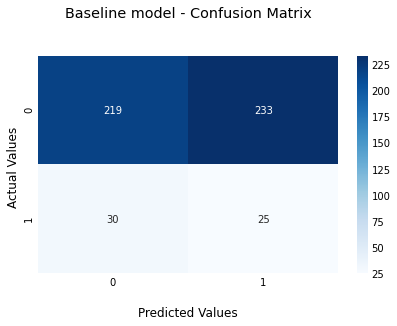

In [36]:
# Define sequence length lookback
sequence_length = 21 # as we will use the past 21 days to make predictions with our LSTM and GRU models later below
# Initialize Dummy Classifier
dummy_clf = DummyClassifier(strategy='uniform',random_state=42)
dummy_clf.fit(X_train_os, y_train_os)
# Make predictions
y_pred_baseline = dummy_clf.predict(X_test_filtered[sequence_length:])
# Classification report
print(classification_report(y_test[sequence_length:], y_pred_baseline))
# Plot confusion matrix with baseline model
cf_matrix_baseline = confusion_matrix(y_test[sequence_length:], y_pred_baseline)
ax = sn.heatmap(cf_matrix_baseline, annot=True, cmap='Blues', fmt='g')
ax.set_title('Baseline model - Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])
plt.show()

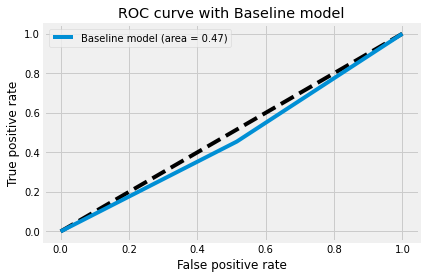

In [38]:
# Plot ROC curve
fpr_baseline, tpr_baseline, thresholds_baseline = roc_curve(y_test[sequence_length:], y_pred_baseline)
auc_baseline = auc(fpr_baseline, tpr_baseline)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_baseline, tpr_baseline, label='Baseline model (area = {:.2f})'.format(auc_baseline))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve with Baseline model')
plt.legend(loc='best')
plt.show()

Our baseline model succeeds to predict negative RV-IV spread moves (219 TN, 25 FN), but fails in accurately predicting positive RV-IV spread moves (30 TP, 233 FP).

## Long-Short Term Memory (LSTM) model

A neural network is an adaptive system that learns by using interconnected nodes or neurons in a layered structure that resembles a human brain. **A neural network can learn from data: it can be trained to recognize patterns, classify data, and forecast future events**.

More particularly, we use Recurrent Neural Networks (RNNs), which are a class of neural networks that are powerful for modeling sequence data such as time series. Schematically, a RNN layer uses a 'for' loop to iterate over the timesteps of a sequence, while maintaining an internal state that encodes information about the timesteps it has seen so far. In particular, **a LSTM network is a type of recurrent neural network (RNN) that can learn long-term dependencies between time steps of sequence data**.

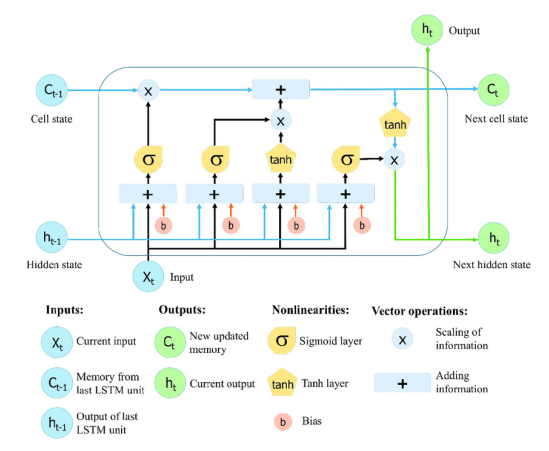

**Time series data must be transformed into a structure of samples with input and output components before it can be used to fit a supervised learning model.** The Keras deep learning library provides the TimeseriesGenerator to automatically transform both univariate and multivariate time series data into samples ready to train deep learning models.

In [89]:
# Define parameters based on oversampled dataset
sequence_length = 21 # e.g. we use the past 21 days to make predictions
nb_features = X_train_os.shape[1]
# Generate train and test sequence data
g = TimeseriesGenerator(X_train_os, y_train_os, length=sequence_length) # X_train_os already incorporate only Choice B features only
g_ = TimeseriesGenerator(X_test[final_features_B], y_test, length=sequence_length)

In [90]:
# Verify batch size
for i in range(len(g)):
    a, b = g[i]
    print(a.shape, b.shape)

(128, 21, 26) (128,)
(128, 21, 26) (128,)
(128, 21, 26) (128,)
(128, 21, 26) (128,)
(128, 21, 26) (128,)
(128, 21, 26) (128,)
(128, 21, 26) (128,)
(128, 21, 26) (128,)
(128, 21, 26) (128,)
(128, 21, 26) (128,)
(128, 21, 26) (128,)
(128, 21, 26) (128,)
(128, 21, 26) (128,)
(128, 21, 26) (128,)
(128, 21, 26) (128,)
(128, 21, 26) (128,)
(128, 21, 26) (128,)
(128, 21, 26) (128,)
(128, 21, 26) (128,)
(128, 21, 26) (128,)
(128, 21, 26) (128,)
(128, 21, 26) (128,)
(128, 21, 26) (128,)
(128, 21, 26) (128,)
(128, 21, 26) (128,)
(128, 21, 26) (128,)
(128, 21, 26) (128,)
(31, 21, 26) (31,)


### Build model

As **the objective of the paper is also to compare LSTM and GRU performance for the same prediction task** and for an aligned set-up, we create a RNN class to build and find hyperparameters for the neural network of our choice.

The LSTM and GRU models have an aligned structure for comparability reasons:

- Stacked structure of 3 hidden layers between an input layer and an output layer
- Dropout regularization for the model to generalize better after the first 2 hidden layers
- Adam optimizer
- Binary Cross Entropy loss function as we deal with a classification problem

Our RNN class (*NN_model*) has two main functions:
- **create**: create the neural network model
- **HPoptim**: create the neural network model for a given set of hyperparameters, used for the tuning process of hyperparameters - see section 5.3 (LSTM) and 6.3 (GRU) below.

In [91]:
class NN_model:
    """
    Class for creating Recurrent Neural Networks
    Attributes: 
        hu          : int
        lookback    : int
        features    : int
        modeltype   : str
    """    
    def __init__(self, hu, lookback, features, modeltype):
        # Hidden units
        self.hu = hu
        # Lookback
        self.lookback = lookback
        # Features
        self.features = features
        # Model: LSTM or GRU
        self.modeltype = modeltype
    
    # Create a sequential model
    def create(self):
        tf.keras.backend.clear_session()
        # Fix random seed for reproducibility
        seed = 2022
        tf.random.set_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        # Instantiate the model
        model = Sequential()
        # First layer
        model.add(eval(self.modeltype)(units=self.hu*2, input_shape=(self.lookback, self.features), activation = 'elu', return_sequences=True, name=str(self.modeltype)+'1'))
        model.add(Dropout(0.4, name='Dropout1'))
        # Second layer
        model.add(eval(self.modeltype)(units=self.hu, activation = 'elu', return_sequences=True, name=str(self.modeltype)+'2'))
        model.add(Dropout(0.4, name='Dropout2'))
        # Third layer
        model.add(eval(self.modeltype)(units=self.hu, activation = 'elu', return_sequences=False, name=str(self.modeltype)+'3'))
        # Output layer
        model.add(Dense(units=1, activation='sigmoid', name='Output'))             
        # Model optimization
        opt = Adam(lr=0.001, epsilon=1e-08, decay=0.0)
        model.compile(optimizer=opt, 
                  loss=BinaryCrossentropy(), 
                  metrics=['accuracy', 
                           Precision(),
                           Recall()])

        return model
    
    def HPoptim(self,hp):
        tf.keras.backend.clear_session()   
        # Fix random seed for reproducibility
        seed = 2022
        tf.random.set_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        # Instantiate the model
        model = Sequential()
        # Tune the number of units in the layers
        hp_units1 = hp.Int('units1', min_value=4, max_value=32, step=4)
        hp_units2 = hp.Int('units2', min_value=4, max_value=32, step=4)
        hp_units3 = hp.Int('units3', min_value=4, max_value=32, step=4)
        # Tune the dropout rate
        hp_dropout1 = hp.Float('Dropout_rate', min_value=0, max_value=0.5, step=0.1)
        hp_dropout2 = hp.Float('Dropout_rate', min_value=0, max_value=0.5, step=0.1)
        # Tune the learning rate for the optimizer
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        # Tune activation functions
        hp_activation1 = hp.Choice(name = 'activation', values = ['relu', 'elu'], ordered = False)
        hp_activation2 = hp.Choice(name = 'activation', values = ['relu', 'elu'], ordered = False)
        hp_activation3 = hp.Choice(name = 'activation', values = ['relu', 'elu'], ordered = False)
        # First layer
        model.add(eval(self.modeltype)(hp_units1, input_shape=(self.lookback, self.features), activation=hp_activation1, return_sequences=True, name= str(self.modeltype)+'1'))   
        model.add(Dropout(hp_dropout1, name='Dropout1'))
        # Second layer
        model.add(eval(self.modeltype)(hp_units2, activation = hp_activation2, return_sequences=True, name=str(self.modeltype)+'2'))
        model.add(Dropout(hp_dropout2, name='Dropout2'))
        # Third layer
        model.add(eval(self.modeltype)(hp_units3, activation = hp_activation3, return_sequences=False, name=str(self.modeltype)+'3'))
        model.add(Dense(units=1, activation='sigmoid', name='Output'))    
        # Model optimization
        opt = Adam(lr=hp_learning_rate, epsilon=1e-08, decay=0.0)
        model.compile(optimizer=opt, 
                  loss=BinaryCrossentropy(), 
                  metrics=['accuracy', 
                           Precision(),
                           Recall()])
        return model

We now initiate our LSTM network based on an initial random set of parameters:

In [92]:
# LSTM network
LSTM_model = NN_model(hu=10, lookback=sequence_length, features=nb_features, modeltype='LSTM').create
# Summary
LSTM_model = LSTM_model()
LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM1 (LSTM)                 (None, 21, 20)            3760      
_________________________________________________________________
Dropout1 (Dropout)           (None, 21, 20)            0         
_________________________________________________________________
LSTM2 (LSTM)                 (None, 21, 10)            1240      
_________________________________________________________________
Dropout2 (Dropout)           (None, 21, 10)            0         
_________________________________________________________________
LSTM3 (LSTM)                 (None, 10)                840       
_________________________________________________________________
Output (Dense)               (None, 1)                 11        
Total params: 5,851
Trainable params: 5,851
Non-trainable params: 0
______________________________________________________

In addition to the dropout technique which allows the LSTM model to generalize better, we also include in the model the Early Stopping regularization technique. **Early Stopping stops the model training as soon as the model performance on the validation (e.g. test) set gets worse. In Keras, Early Stopping happens in what is called a callback function**. One of the parameters of the callback function is the 'Patience', which denotes the number of epochs with no further improvement after which the training stops. 

In [93]:
# Create path to store LSTM model results
LSTM_results_path = Path('results', 'LSTM_time_series')
if not LSTM_results_path.exists():
    LSTM_results_path.mkdir(parents=True)

# Specify callback functions
LSTM_model_path = (LSTM_results_path / 'model.h5').as_posix()
logdir = os.path.join('./tensorboard/logs', dt.datetime.now().strftime('%Y%m%d-%H%M%S'))

my_LSTM_callbacks = [
    EarlyStopping(patience=20, monitor='loss', mode='min', verbose=1, restore_best_weights=True),
    ModelCheckpoint(filepath=LSTM_model_path, verbose=1, monitor='loss', save_best_only=True),
    TensorBoard(log_dir=logdir, histogram_freq=1)
]

# Class weight function
def cwts(dfs):
    c0, c1 = np.bincount(dfs['Label'])
    w0=(1/c0)*(len(dfs))/2 
    w1=(1/c1)*(len(dfs))/2 
    return {0: w0, 1: w1}
class_weight = cwts(df)

We now fit the LSTM model on the train dataset. **Dropout and Early stopping regularization techniques are now in place for the LSTM to generalize as best as possible**.

In [94]:
# Model fitting
LSTM_history = LSTM_model.fit(g,
          epochs=500, 
          verbose=1, 
          callbacks=my_LSTM_callbacks, 
          shuffle=False,
          class_weight=class_weight)

Epoch 1/500
28/28 [==============================] - 4s 48ms/step - loss: 1.2285 - accuracy: 0.8185 - precision: 0.9878 - recall: 0.6471

Epoch 00001: loss improved from inf to 1.22854, saving model to results/LSTM_time_series\model.h5
Epoch 2/500
28/28 [==============================] - 1s 31ms/step - loss: 0.8321 - accuracy: 0.5030 - precision: 0.5030 - recall: 1.0000

Epoch 00002: loss improved from 1.22854 to 0.83210, saving model to results/LSTM_time_series\model.h5
Epoch 3/500
28/28 [==============================] - 1s 28ms/step - loss: 1.0514 - accuracy: 0.5030 - precision: 0.5030 - recall: 1.0000

Epoch 00003: loss did not improve from 0.83210
Epoch 4/500
28/28 [==============================] - 1s 28ms/step - loss: 0.8756 - accuracy: 0.5030 - precision: 0.5030 - recall: 1.0000

Epoch 00004: loss did not improve from 0.83210
Epoch 5/500
28/28 [==============================] - 1s 29ms/step - loss: 0.8734 - accuracy: 0.5030 - precision: 0.5030 - recall: 1.0000

Epoch 00005: los

28/28 [==============================] - 1s 30ms/step - loss: 0.1800 - accuracy: 0.9042 - precision: 0.8457 - recall: 0.9903

Epoch 00076: loss did not improve from 0.17921
Epoch 77/500
28/28 [==============================] - 1s 30ms/step - loss: 0.2011 - accuracy: 0.9005 - precision: 0.8460 - recall: 0.9806

Epoch 00077: loss did not improve from 0.17921
Epoch 78/500
28/28 [==============================] - 1s 29ms/step - loss: 0.1912 - accuracy: 0.9100 - precision: 0.8554 - recall: 0.9880

Epoch 00078: loss did not improve from 0.17921
Epoch 79/500
28/28 [==============================] - 1s 29ms/step - loss: 0.1911 - accuracy: 0.8965 - precision: 0.8344 - recall: 0.9909

Epoch 00079: loss did not improve from 0.17921
Epoch 80/500
28/28 [==============================] - 1s 29ms/step - loss: 0.2147 - accuracy: 0.8988 - precision: 0.8425 - recall: 0.9823

Epoch 00080: loss did not improve from 0.17921
Epoch 81/500
28/28 [==============================] - 1s 31ms/step - loss: 0.1698 -

Epoch 158/500
28/28 [==============================] - 1s 29ms/step - loss: 0.1426 - accuracy: 0.9240 - precision: 0.8754 - recall: 0.9897

Epoch 00158: loss did not improve from 0.12329
Epoch 159/500
28/28 [==============================] - 1s 29ms/step - loss: 0.1344 - accuracy: 0.9260 - precision: 0.8782 - recall: 0.9903

Epoch 00159: loss did not improve from 0.12329
Epoch 160/500
28/28 [==============================] - 1s 30ms/step - loss: 0.1532 - accuracy: 0.9074 - precision: 0.8495 - recall: 0.9914

Epoch 00160: loss did not improve from 0.12329
Epoch 161/500
28/28 [==============================] - 1s 32ms/step - loss: 0.1497 - accuracy: 0.9148 - precision: 0.8605 - recall: 0.9914

Epoch 00161: loss did not improve from 0.12329
Epoch 162/500
28/28 [==============================] - 1s 30ms/step - loss: 0.2095 - accuracy: 0.8927 - precision: 0.8311 - recall: 0.9875

Epoch 00162: loss did not improve from 0.12329
Epoch 163/500
28/28 [==============================] - 1s 29ms/st

The graph below illustrates the evolution of the training loss, but also the accuracy, recall and precision as number of epochs increase. Fluctuations in training over loss epochs are the consequence of neural networks being trained with different forms of stochastic gradient descent.

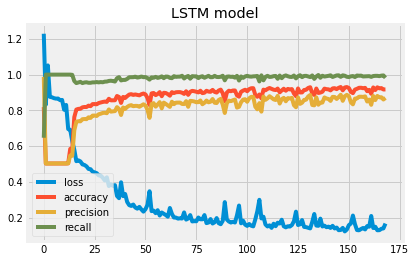

In [95]:
# Plot loss functions
plt.plot(LSTM_history.history['loss'], label='loss')
plt.plot(LSTM_history.history['accuracy'], label='accuracy')
plt.plot(LSTM_history.history['precision'], label='precision')
plt.plot(LSTM_history.history['recall'], label='recall')
plt.title('LSTM model')
plt.legend()
plt.show()

### Evaluate model performance

Classification models have a discrete output, and therefore require an evaluation metric which compares discrete classes in some form. Classification metrics evaluate a model performance and indicate how good or bad the classification is. The most popular metrics to evaluate a classification prediction model are:
- Accuracy
- Precision and Recall
- F1 score
- AUC ROC

To note that the confusion matrix, despite not being a metric, is fundamental when evaluating a classification model.

**Accuracy metrics must be used with caution on imbalanced datasets, as evaluation results will be biased**. To give a few examples:
- when using accuracy on an imbalanced problem, it is easy to get a high accuracy score by simply classifying all observations as the majority class
- when using the ROC curve on an imbalanced problem, false positive rate is pulled down due to a large number of true negatives

**The class imbalance problem has been addressed in section 3 above. Our evaluation measures and results are therefore coherent, as we now work with the SMOTE (oversampled) Choice B feature set**.

In [96]:
# Evaluate the LSTM model
LSTM_score_train = LSTM_model.evaluate(g, verbose=0)
LSTM_score_test = LSTM_model.evaluate(g_, verbose=0)
print(f'Train Accuracy:  {LSTM_score_train[1]*100:.4}%')
print(f'Test Accuracy:  {LSTM_score_test[1]*100:.4}%')

Train Accuracy:  94.29%
Test Accuracy:  65.48%


We start by measuring the accuracy of our LSTM model with a random set of hyper parameters on train and test sets. Results are encouraging, as the model performs well out-of sample with an accuracy of 65%. We note as well that the LSTM model has a tendency to overfit, as the in-sample performance is strongly above the out-of-sample performance. The classification report illustrates that the model performs well in predicting class 0 (negative RV-IV spread), but struggles more in predicting class 1 (positive RV-IV spread).

In [97]:
# Classification report
y_pred_LSTM = np.where(LSTM_model.predict(g_, verbose=False) > 0.5, 1, 0)
print(classification_report(y_test[sequence_length:], y_pred_LSTM))

              precision    recall  f1-score   support

           0       0.99      0.62      0.76       452
           1       0.23      0.93      0.37        55

    accuracy                           0.65       507
   macro avg       0.61      0.77      0.57       507
weighted avg       0.90      0.65      0.72       507



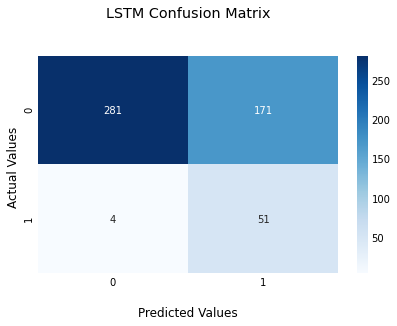

In [98]:
# Plot confusion matrix
cf_matrix_LSTM = confusion_matrix(y_test[sequence_length:], y_pred_LSTM)
ax = sn.heatmap(cf_matrix_LSTM, annot=True, cmap='Blues', fmt='g')
ax.set_title('LSTM Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])
plt.show()

We - happily - note that with our random set of hyper parameters, **our LSTM classification model also performs better than our baseline model**, as we have more true predictions and less false predictions. **The ROC curve confirms that the model is able to distinguish between the two classes**, as the AUC scores to 77%.

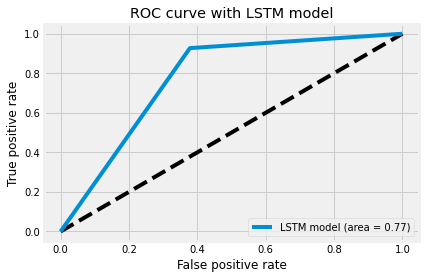

In [133]:
# Plot ROC curve
fpr_LSTM, tpr_LSTM, thresholds_LSTM = roc_curve(y_test[sequence_length:], y_pred_LSTM)
auc_LSTM = auc(fpr_LSTM, tpr_LSTM)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_LSTM, tpr_LSTM, label='LSTM model (area = {:.2f})'.format(auc_LSTM))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve with LSTM model')
plt.legend(loc='best')
plt.show()

In [ ]:
# Tensorboard model evaluation
%tensorboard --logdir ./tensorboard/logs

### Hyperparameter tuning

Now that our LSTM is built, we optimize the hyperparameters in order to get the best model possible. The process of choosing a set of optimal hyperparameters for a learning algorithm is called hyperparameter tuning or optimization. **Hyperparameters are parameters whose values are set before the learning process begins. By contrast, the value of simple parameters are derived via training the data**. In the case of a Neural Network, hyperparameters can be:
- number of hidden layers
- number of neurons
- learning rate
- activation function
- etc

Tuning and finding the right hyperparameters for our model is an optimization problem, as we want to minimize the loss function of our model by changing model parameters. They are a crucial step in a model development inasmuch as they drive the model's performance and speed as well as the quality of the predictions. Wikipedia sums it best: "**Hyperparameter optimization finds a tuple of hyperparameters that yields an optimal model which minimizes a predefined loss function on given test data. The objective function takes a tuple of hyperparameters and returns the associated loss**".


Various techniques exist such as Grid Search or Random Search, as illustrated in the picture below.

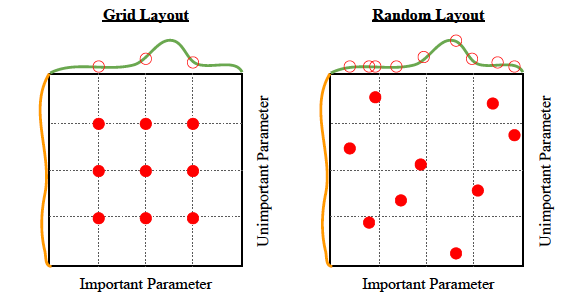

Another hyperparameter optimization is the Bayesian approach. **Bayesian methods attempt to build a function (more accurately, a probability distribution over possible function) that estimates how good your model might be for a certain choice of hyperparameters**. By using this approximate function (called a surrogate function), we do not have to go through the 'set, train, and evaluate' loop too many times, since only the surrogate function hyperparameters need to be optimized. **In short, a Bayesian Optimization runs models many times with different sets of hyperparameter values, and it evaluates the past model information to select hyperparameter values to build the newer model**.

We start the Bayesian Optimization of hyperparameters by setting up Early stopping as above, in order to avoid overfitting.

In [100]:
# Initialize early stopping, prevents model from overfitting/spending too much time training with minimal gains
LSTM_callback = [EarlyStopping(patience=10, monitor='loss', mode='min', verbose=1, restore_best_weights=True),
             TensorBoard(log_dir="./tensorboard/bologs")]

# BayesianOptimization algorithm from keras tuner
LSTM_botuner = BayesianOptimization(
    NN_model(hu=10, lookback=sequence_length, features=nb_features, modeltype='LSTM').HPoptim,
    objective='val_accuracy',
    max_trials=15,
    num_initial_points=2,
    hyperparameters=None,
    tune_new_entries=True,
    allow_new_entries=True,
    overwrite=True,
    directory="./keras",
    project_name="botrial")

# Launch tuning process
LSTM_botuner.search(g, epochs=50, validation_data=g_, callbacks=LSTM_callback, class_weight = class_weight, shuffle=False)

Trial 15 Complete [00h 01m 05s]
val_accuracy: 0.7672584056854248

Best val_accuracy So Far: 0.8520709872245789
Total elapsed time: 00h 15m 18s
INFO:tensorflow:Oracle triggered exit


In [101]:
# Display the best hyperparameter values for the model based on the defined objective function
LSTM_best_bohp = LSTM_botuner.get_best_hyperparameters()[0]
print(LSTM_best_bohp.values)

{'units1': 32, 'units2': 32, 'units3': 32, 'Dropout_rate': 0.0, 'learning_rate': 0.0001, 'activation': 'elu'}


Results of the Bayesian optimization of hyperparameters leads to the following values for our final LSTM model:
- best number of nodes for the input layer: 32
- best number of nodes for the hidden layer: 2
- best number of nodes for the final layer: 32
- best dropout rate: 0
- best learning rate: 0.0001
- best activation function: elu
- best accuracy score: 85%

We now use the best hyperparameters that we have found with the Bayesian Optimization to **build an optimal LSTM model for our classification problem**.

In [102]:
# Define final model with tuned hyperparameters
final_LSTM_model = NN_model(hu=10, lookback=sequence_length, features=nb_features, modeltype='LSTM').HPoptim(LSTM_best_bohp)
# Model fitting
final_LSTM_history = final_LSTM_model.fit(g,
          epochs=500, 
          verbose=1, 
          callbacks=my_LSTM_callbacks, 
          shuffle=False,
          class_weight=class_weight)

Epoch 1/500
28/28 [==============================] - 4s 55ms/step - loss: 1.3430 - accuracy: 0.6077 - precision: 1.0000 - recall: 0.2201 

Epoch 00001: loss did not improve from 0.12329
Epoch 2/500
28/28 [==============================] - 1s 50ms/step - loss: 1.1971 - accuracy: 0.5030 - precision: 0.5030 - recall: 1.0000

Epoch 00002: loss did not improve from 0.12329
Epoch 3/500
28/28 [==============================] - 1s 42ms/step - loss: 1.0454 - accuracy: 0.5030 - precision: 0.5030 - recall: 1.0000: 1s - loss: 0.7107 - accuracy: 0.1615 - precision: 0.1615 - reca

Epoch 00003: loss did not improve from 0.12329
Epoch 4/500
28/28 [==============================] - 1s 36ms/step - loss: 0.8643 - accuracy: 0.5030 - precision: 0.5030 - recall: 1.0000

Epoch 00004: loss did not improve from 0.12329
Epoch 5/500
28/28 [==============================] - 1s 38ms/step - loss: 0.7737 - accuracy: 0.5030 - precision: 0.5030 - recall: 1.0000

Epoch 00005: loss did not improve from 0.12329
Epoch 6/5

28/28 [==============================] - 1s 45ms/step - loss: 0.2141 - accuracy: 0.8916 - precision: 0.8282 - recall: 0.9897

Epoch 00088: loss did not improve from 0.12329
Epoch 89/500
28/28 [==============================] - 1s 40ms/step - loss: 0.2121 - accuracy: 0.8927 - precision: 0.8298 - recall: 0.9897

Epoch 00089: loss did not improve from 0.12329
Epoch 90/500
28/28 [==============================] - 1s 41ms/step - loss: 0.2102 - accuracy: 0.8930 - precision: 0.8302 - recall: 0.9897

Epoch 00090: loss did not improve from 0.12329
Epoch 91/500
28/28 [==============================] - 1s 40ms/step - loss: 0.2083 - accuracy: 0.8936 - precision: 0.8307 - recall: 0.9903: 0s - loss: 0.2083 - accuracy: 0.8936 - precision: 0.8307 - recall: 0.990

Epoch 00091: loss did not improve from 0.12329
Epoch 92/500
28/28 [==============================] - 1s 41ms/step - loss: 0.2065 - accuracy: 0.8942 - precision: 0.8315 - recall: 0.9903

Epoch 00092: loss did not improve from 0.12329
Epoch 93/

28/28 [==============================] - 1s 42ms/step - loss: 0.1464 - accuracy: 0.9274 - precision: 0.8812 - recall: 0.9892: 1s - loss: 0.2328 - accuracy: 0.8672 - precision: 0.4603 - 

Epoch 00174: loss did not improve from 0.12329
Epoch 175/500
28/28 [==============================] - 1s 42ms/step - loss: 0.1581 - accuracy: 0.9191 - precision: 0.8684 - recall: 0.9892

Epoch 00175: loss did not improve from 0.12329
Epoch 176/500
28/28 [==============================] - 1s 43ms/step - loss: 0.1654 - accuracy: 0.9143 - precision: 0.8621 - recall: 0.9875
Restoring model weights from the end of the best epoch.

Epoch 00176: loss did not improve from 0.12329
Epoch 00176: early stopping


We plot again the evolution of loss, accuracy, precision and recall as per the number of epochs for our final LSTM model. As above, fluctuations in training over loss epochs are the consequence of neural networks being trained with different forms of stochastic gradient descent - although fluctuations are less pronounced here. **All accuracy metrics plateau after 100 epochs**.

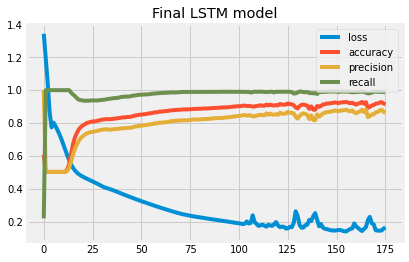

In [136]:
# Plot loss functions
plt.plot(final_LSTM_history.history['loss'], label='loss')
plt.plot(final_LSTM_history.history['accuracy'], label='accuracy')
plt.plot(final_LSTM_history.history['precision'], label='precision')
plt.plot(final_LSTM_history.history['recall'], label='recall')
plt.title('Final LSTM model')
plt.legend()
plt.show()

### Evaluate tuned model performance

As above, **we evaluate the performance of our LSTM model run with the best hyperparameters**, and compare both Train and Test accuracy before and after the Bayesian Optimization.

In [104]:
# Evaluate the LSTM model with best parameters
final_LSTM_score_train = final_LSTM_model.evaluate(g, verbose=0)
final_LSTM_score_test = final_LSTM_model.evaluate(g_, verbose=0)
print(f'Train Accuracy: {final_LSTM_score_train[1]*100:.4}% | Model improvement: {(final_LSTM_score_train[1]/LSTM_score_train[1]-1)*100:.4}%')
print(f'Test Accuracy: {final_LSTM_score_test[1]*100:.4}% | Model improvement: {(final_LSTM_score_test[1]/LSTM_score_test[1]-1)*100:.4}%')

Train Accuracy: 91.94% | Model improvement: -2.494%
Test Accuracy: 80.47% | Model improvement: 22.89%


**Bayesian Optimization resulted in a much better LSTM model** for two main reasons:
- The model is less prone to overfitting and generalizes better, as train accuracy decreased while test accuracy increased.
- Test accuracy improved by 23%. A performance accuracy in out-of-sample prediction of 80% is a great score.

In [105]:
# LSTM lassification report with best parameters
final_y_pred_LSTM = np.where(final_LSTM_model.predict(g_, verbose=False) > 0.5, 1, 0)
print(classification_report(y_test[sequence_length:], final_y_pred_LSTM))

              precision    recall  f1-score   support

           0       0.95      0.82      0.88       452
           1       0.31      0.65      0.42        55

    accuracy                           0.80       507
   macro avg       0.63      0.74      0.65       507
weighted avg       0.88      0.80      0.83       507



The confusion matrix validates that our LSTM with the optimal set of hyperparameters performs well, as **true predictions largely exceed false predictions**.

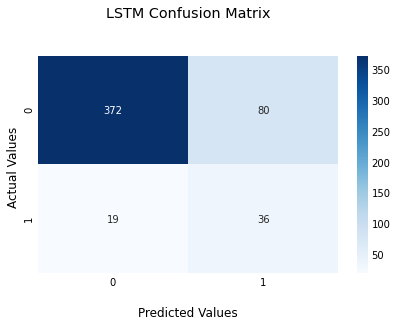

In [106]:
# Plot confusion matrix
final_cf_matrix_LSTM = confusion_matrix(y_test[sequence_length:], final_y_pred_LSTM)
ax = sn.heatmap(final_cf_matrix_LSTM, annot=True, cmap='Blues', fmt='g')
ax.set_title('LSTM Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])
plt.show()

Finally, **the ROC curve confirms final LSTM model's ability to distinguish between the two classes**, as the AUC score sums to 74%.

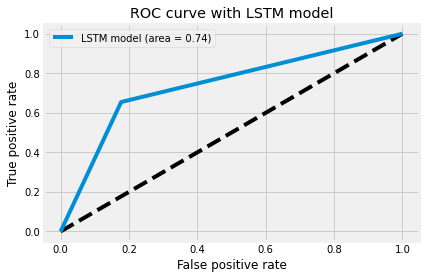

In [134]:
# Plot ROC curve
fpr_final_LSTM, tpr_final_LSTM, thresholds_final_LSTM = roc_curve(y_test[sequence_length:], final_y_pred_LSTM)
final_auc_LSTM = auc(fpr_final_LSTM, tpr_final_LSTM)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_final_LSTM, tpr_final_LSTM, label='LSTM model (area = {:.2f})'.format(final_auc_LSTM))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve with LSTM model')
plt.legend(loc='best')
plt.show()

In [ ]:
# Tensorboard model evaluation
%tensorboard --logdir ./tensorboard/logs

### Model backtest

As a final step, we visualize our LSTM model predictions of the SP500 RV-IV spread on the next trading day against observed realized and implied volatility.

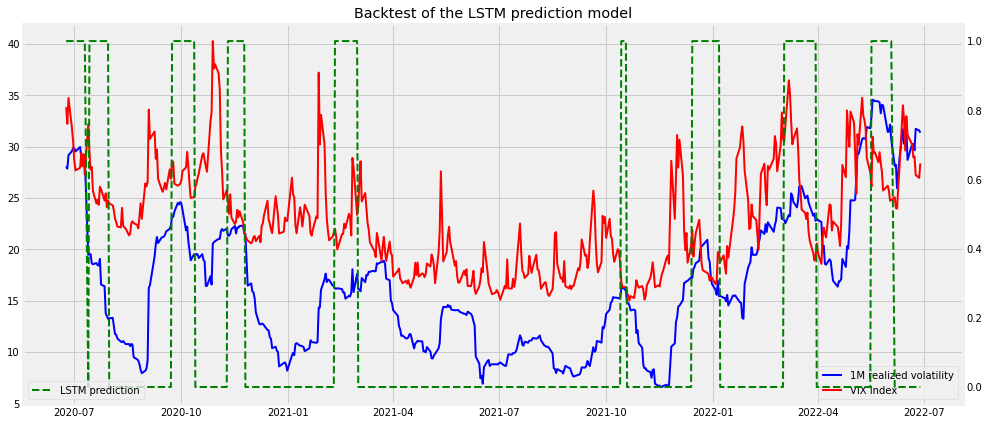

In [108]:
# Resume main variables of interest in a dataframe
df_ = y_test[sequence_length:]
LSTM_predicted = pd.DataFrame(final_y_pred_LSTM, index=df_.index)
LSTM_predicted.columns = ['Predicted']
LSTM_strategy = pd.concat([df[['Adj Close','Return','Label','Volatility_21d','VIX']], LSTM_predicted], axis=1).dropna()
# Model backtest
fig, ax1 = plt.subplots(figsize=(15,7));
ax2 = ax1.twinx()
ax1.plot(LSTM_strategy.index,LSTM_strategy['Volatility_21d']*100*(252)**0.5, 'b-', linewidth=2,label='1M realized volatility')
ax1.plot(LSTM_strategy.index,LSTM_strategy['VIX'], 'r-',linewidth=2,label = 'VIX Index')
ax1.legend(loc='lower right')
ax2.plot(LSTM_strategy.index, LSTM_strategy['Predicted'], 'g--', linewidth=2, label = 'LSTM prediction')
ax2.grid(False)
ax2.legend(loc='lower left');
plt.title('Backtest of the LSTM prediction model');

We note that **observed and predicted volatility spread signal are most of the time consistent!**
- Our LSTM prediction model correctly predicts all instances where the realized volatility is above the implied volatility
- Although our LSTM model is sometimes wrong in predicting a positive RV-IV spread, we note that the model was close from being right, as wrong predictions were driven by a sharp increase in realized volatility which brought it close - but still below, the implied volatility.

## Gated Reccurent Units (GRU) model

As mentioned above, and unlike Feed Forward Neural Networks, **RNNs contain recurrent units in their hidden layers, which allow the algorithm to process sequence data**. This is done by recurrently passing hidden states from previous timesteps and combining them with inputs of the current one. **GRU is an alternative cell design that uses fewer parameters and computes faster compared to LSTM**. GRU is similar to LSTM, but it has fewer gates. Also, it relies solely on a hidden state for memory transfer between recurrent units, so there is no separate cell state.

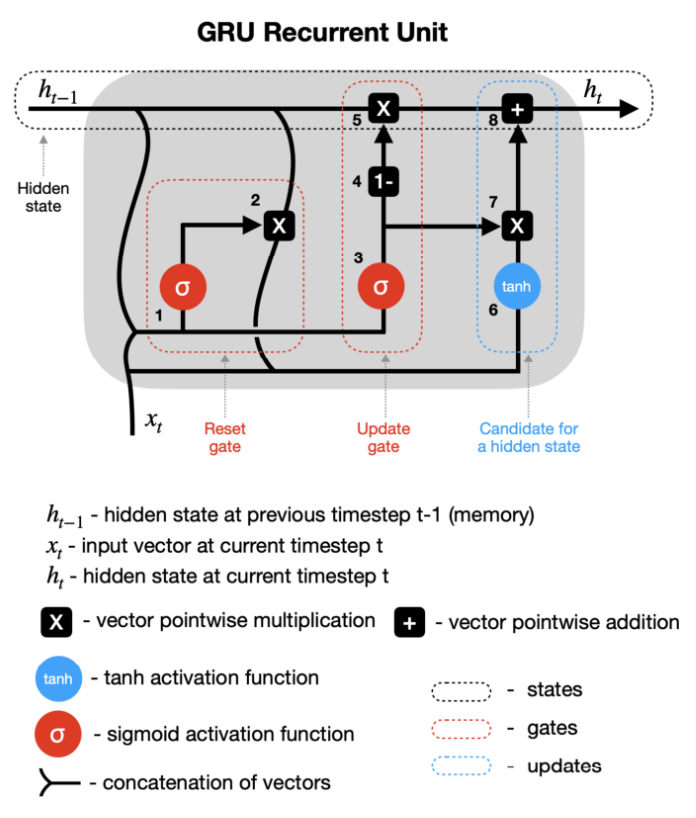

**The idea of section 6 is to go through exactly the exact same process than section 5, but with a GRU model rather than a LSTM model, in order to compare the performance of the two for an aligned set-up**. Of course, GRU and LSTM model final models will be based on different hyperparameters, as per the stochastic nature of the Bayesian optimization, nevertheless the layer structure remains the same.

As a reminder: The LSTM and GRU models have an aligned structure for comparability reasons:

- Stacked structure of 3 hidden layers between an input layer and an output layer
- Dropout regularization for the model to generalize better after the first two hidden layers
- Adam optimizer
- Binary Cross Entropy loss function as we deal with a classification problem

### Build model

As for the LSTM initialization, we set up our GRU model based on a random set of hyper parameters.

In [109]:
# GRU network
GRU_model = NN_model(hu=10, lookback=sequence_length, features=nb_features, modeltype='GRU').create
# GRU model summary
GRU_model = GRU_model()
GRU_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GRU1 (GRU)                   (None, 21, 20)            2880      
_________________________________________________________________
Dropout1 (Dropout)           (None, 21, 20)            0         
_________________________________________________________________
GRU2 (GRU)                   (None, 21, 10)            960       
_________________________________________________________________
Dropout2 (Dropout)           (None, 21, 10)            0         
_________________________________________________________________
GRU3 (GRU)                   (None, 10)                660       
_________________________________________________________________
Output (Dense)               (None, 1)                 11        
Total params: 4,511
Trainable params: 4,511
Non-trainable params: 0
______________________________________________________

As above, we set-up Early Stopping to prevent our GRU model from overfitting, so it can generalize better.

In [110]:
# Create path to store GRU model results
GRU_results_path = Path('results', 'GRU_time_series')
if not GRU_results_path.exists():
    GRU_results_path.mkdir(parents=True)

# Specify callback functions
GRU_model_path = (GRU_results_path / 'model.h5').as_posix()
logdir = os.path.join('./tensorboard/logs', dt.datetime.now().strftime('%Y%m%d-%H%M%S'))

my_GRU_callbacks = [
    EarlyStopping(patience=20, monitor='loss', mode='min', verbose=1, restore_best_weights=True),
    ModelCheckpoint(filepath=GRU_model_path, verbose=1, monitor='loss', save_best_only=True),
    TensorBoard(log_dir=logdir, histogram_freq=1)
]

# Produce class weights
class_weight = cwts(df)

We now fit the GRU model on the train dataset. Dropout and Early stopping regularization technique are now in place for the GRU to generalize as best as possible.

In [111]:
# Model fitting
GRU_history = GRU_model.fit(g,
          epochs=500, 
          verbose=1, 
          callbacks=my_GRU_callbacks, 
          shuffle=False,
          class_weight=class_weight)

Epoch 1/500
28/28 [==============================] - 5s 60ms/step - loss: 1.1336 - accuracy: 0.7496 - precision: 0.7260 - recall: 0.8067

Epoch 00001: loss improved from inf to 1.13356, saving model to results/GRU_time_series\model.h5
Epoch 2/500
28/28 [==============================] - 1s 28ms/step - loss: 0.8003 - accuracy: 0.5030 - precision: 0.5030 - recall: 1.0000

Epoch 00002: loss improved from 1.13356 to 0.80035, saving model to results/GRU_time_series\model.h5
Epoch 3/500
28/28 [==============================] - 1s 28ms/step - loss: 0.8672 - accuracy: 0.5030 - precision: 0.5030 - recall: 1.0000

Epoch 00003: loss did not improve from 0.80035
Epoch 4/500
28/28 [==============================] - 1s 28ms/step - loss: 0.8585 - accuracy: 0.5030 - precision: 0.5030 - recall: 1.0000

Epoch 00004: loss did not improve from 0.80035
Epoch 5/500
28/28 [==============================] - 1s 27ms/step - loss: 0.8467 - accuracy: 0.5030 - precision: 0.5030 - recall: 1.0000

Epoch 00005: loss 

28/28 [==============================] - 1s 30ms/step - loss: 0.1937 - accuracy: 0.9125 - precision: 0.8639 - recall: 0.9806

Epoch 00075: loss improved from 0.19608 to 0.19370, saving model to results/GRU_time_series\model.h5
Epoch 76/500
28/28 [==============================] - 1s 29ms/step - loss: 0.1880 - accuracy: 0.9071 - precision: 0.8512 - recall: 0.9880

Epoch 00076: loss improved from 0.19370 to 0.18795, saving model to results/GRU_time_series\model.h5
Epoch 77/500
28/28 [==============================] - 1s 29ms/step - loss: 0.1966 - accuracy: 0.9013 - precision: 0.8446 - recall: 0.9852

Epoch 00077: loss did not improve from 0.18795
Epoch 78/500
28/28 [==============================] - 1s 29ms/step - loss: 0.1999 - accuracy: 0.9019 - precision: 0.8431 - recall: 0.9892

Epoch 00078: loss did not improve from 0.18795
Epoch 79/500
28/28 [==============================] - 1s 29ms/step - loss: 0.2448 - accuracy: 0.8787 - precision: 0.8192 - recall: 0.9738

Epoch 00079: loss did 

Epoch 156/500
28/28 [==============================] - 1s 30ms/step - loss: 0.1391 - accuracy: 0.9183 - precision: 0.8634 - recall: 0.9949

Epoch 00156: loss did not improve from 0.13641
Epoch 157/500
28/28 [==============================] - 1s 29ms/step - loss: 0.1427 - accuracy: 0.9174 - precision: 0.8614 - recall: 0.9960

Epoch 00157: loss did not improve from 0.13641
Epoch 158/500
28/28 [==============================] - 1s 30ms/step - loss: 0.1539 - accuracy: 0.9145 - precision: 0.8629 - recall: 0.9869

Epoch 00158: loss did not improve from 0.13641
Epoch 159/500
28/28 [==============================] - 1s 29ms/step - loss: 0.1375 - accuracy: 0.9237 - precision: 0.8739 - recall: 0.9914

Epoch 00159: loss did not improve from 0.13641
Epoch 160/500
28/28 [==============================] - 1s 29ms/step - loss: 0.1407 - accuracy: 0.9191 - precision: 0.8647 - recall: 0.9949

Epoch 00160: loss did not improve from 0.13641
Epoch 161/500
28/28 [==============================] - 1s 30ms/st

The graph below illustrates the evolution of the training loss, but also the accuracy, recall and precision as number of epochs increase for our GRU model. Fluctuations in training over loss epochs are the consequence of neural networks being trained with different forms of stochastic gradient descent.

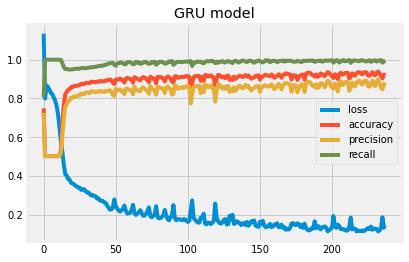

In [112]:
# Plot loss functions
plt.plot(GRU_history.history['loss'], label='loss')
plt.plot(GRU_history.history['accuracy'], label='accuracy')
plt.plot(GRU_history.history['precision'], label='precision')
plt.plot(GRU_history.history['recall'], label='recall')
plt.title('GRU model')
plt.legend()
plt.show()

### Evaluate model performance

In [113]:
# Evaluate the GRU model
GRU_score_train = GRU_model.evaluate(g, verbose=0)
GRU_score_test = GRU_model.evaluate(g_, verbose=0)
print(f'Train Accuracy:  {GRU_score_train[1]*100:.4}%')
print(f'Test Accuracy:  {GRU_score_test[1]*100:.4}%')

Train Accuracy:  94.84%
Test Accuracy:  73.57%


Performance results are encouraging, as the GRU model performs well out-of sample with an accuracy of 74%. The classification report below illustrates that the model performs well in predicting class 0 (negative RV-IV spread), but struggles more in predicting class 1 (positive RV-IV spread).

In [114]:
# Classification report
y_pred_GRU = np.where(GRU_model.predict(g_, verbose=False) > 0.5, 1, 0)
print(classification_report(y_test[sequence_length:], y_pred_GRU))

              precision    recall  f1-score   support

           0       0.99      0.71      0.83       452
           1       0.29      0.96      0.44        55

    accuracy                           0.74       507
   macro avg       0.64      0.84      0.63       507
weighted avg       0.92      0.74      0.79       507



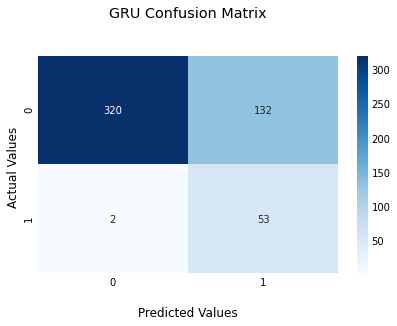

In [115]:
# Plot confusion matrix
cf_matrix_GRU = confusion_matrix(y_test[sequence_length:], y_pred_GRU)
ax = sn.heatmap(cf_matrix_GRU, annot=True, cmap='Blues', fmt='g')
ax.set_title('GRU Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])
plt.show();

We - happily - note that with our random set of hyper parameters, **our GRU classification model performs better than our baseline model**, as we have more true predictions and less false predictions. **The ROC curve confirms that the model is able to correctly distinguish between the two classes**, as the AUC score reaches 84%.

We also note that **at the same stage, the GRU model outperforms the LSTM model**, as it has more true predictions and less false predictions.

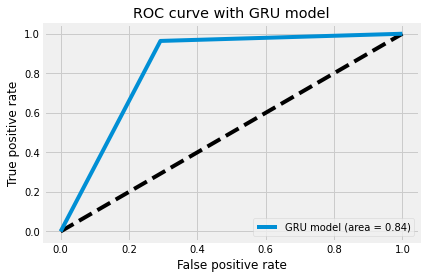

In [138]:
# Plot ROC curve
fpr_GRU, tpr_GRU, thresholds_GRU = roc_curve(y_test[sequence_length:], y_pred_GRU)
auc_GRU = auc(fpr_GRU, tpr_GRU)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_GRU, tpr_GRU, label='GRU model (area = {:.2f})'.format(auc_GRU))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve with GRU model')
plt.legend(loc='best')
plt.show()

### Hyperparameter tuning

As for the LSTM model, we conduct a **Bayesian Optimization in order to find the best hyperparameters for our GRU model**. As a reminder, the **Early Stopping that we set up at first is a regularization technique** in order to prevent the model from overfitting.

In [117]:
# Define the call back function
GRU_callback = [EarlyStopping(patience=10, monitor='loss', mode='min', verbose=1, restore_best_weights=True),
             TensorBoard(log_dir="./tensorboard/bologs")]

# BayesianOptimization algorithm from keras tuner
GRU_botuner = BayesianOptimization(
    NN_model(hu=10, lookback=sequence_length, features=nb_features, modeltype='GRU').HPoptim,
    objective='val_accuracy',
    max_trials=15,
    num_initial_points=2,
    hyperparameters=None,
    tune_new_entries=True,
    allow_new_entries=True,
    overwrite=True,
    directory="./keras",
    project_name="botrial")

# Run the tuning process
GRU_botuner.search(g, epochs=50, validation_data=g_, callbacks=GRU_callback, class_weight = class_weight, shuffle=False)

Trial 15 Complete [00h 00m 53s]
val_accuracy: 0.108481265604496

Best val_accuracy So Far: 0.8954635262489319
Total elapsed time: 00h 12m 20s
INFO:tensorflow:Oracle triggered exit


In [118]:
# Display the best hyperparameter values for the model based on the defined objective function
GRU_best_bohp = GRU_botuner.get_best_hyperparameters()[0]
print(GRU_best_bohp.values)

{'units1': 8, 'units2': 4, 'units3': 20, 'Dropout_rate': 0.4, 'learning_rate': 0.01, 'activation': 'elu'}


Results of the Bayesian optimization of hyperparameters leads to the following conclusion for our final GRU model:
- best number of nodes for the input layer: 8
- best number of nodes for the hidden layer: 4
- best number of nodes for the final layer: 20
- best dropout rate: 0.4
- best learning rate: 0.01
- best activation function: elu
- best accuracy score of 90%

We now use the best hyperparameters that we have found with the Bayesian Optimization to **build an optimal GRU model for our classification problem**.

In [119]:
# Define final model with tuned hyperparameters
final_GRU_model = NN_model(hu=10, lookback=sequence_length, features=nb_features, modeltype='GRU').HPoptim(GRU_best_bohp)
# Model fitting
final_GRU_history = final_GRU_model.fit(g,
          epochs=500, 
          verbose=1, 
          callbacks=my_GRU_callbacks, 
          shuffle=False,
          class_weight=class_weight)

Epoch 1/500
28/28 [==============================] - 5s 47ms/step - loss: 0.5176 - accuracy: 0.7777 - precision: 0.7242 - recall: 0.9014

Epoch 00001: loss did not improve from 0.11521
Epoch 2/500
28/28 [==============================] - 1s 31ms/step - loss: 2.9868 - accuracy: 0.3978 - precision: 0.4319 - recall: 0.6260

Epoch 00002: loss did not improve from 0.11521
Epoch 3/500
28/28 [==============================] - 1s 25ms/step - loss: 0.9383 - accuracy: 0.5030 - precision: 0.5030 - recall: 1.0000

Epoch 00003: loss did not improve from 0.11521
Epoch 4/500
28/28 [==============================] - 1s 25ms/step - loss: 0.9327 - accuracy: 0.5030 - precision: 0.5030 - recall: 1.0000

Epoch 00004: loss did not improve from 0.11521
Epoch 5/500
28/28 [==============================] - 1s 28ms/step - loss: 0.5296 - accuracy: 0.7086 - precision: 0.6437 - recall: 0.9424

Epoch 00005: loss did not improve from 0.11521
Epoch 6/500
28/28 [==============================] - 1s 29ms/step - loss: 1


Epoch 00086: loss did not improve from 0.11521
Epoch 87/500
28/28 [==============================] - 1s 27ms/step - loss: 0.2466 - accuracy: 0.8572 - precision: 0.7913 - recall: 0.9726

Epoch 00087: loss did not improve from 0.11521
Epoch 88/500
28/28 [==============================] - 1s 27ms/step - loss: 0.1807 - accuracy: 0.9039 - precision: 0.8497 - recall: 0.9829

Epoch 00088: loss did not improve from 0.11521
Epoch 89/500
28/28 [==============================] - 1s 27ms/step - loss: 0.1749 - accuracy: 0.9031 - precision: 0.8464 - recall: 0.9863
Restoring model weights from the end of the best epoch.

Epoch 00089: loss did not improve from 0.11521
Epoch 00089: early stopping


We plot again the evolution of loss, accuracy, precision and recall as per the number of epochs for our final GRU model. As above, fluctuations in training over loss epochs are the consequence of neural networks being trained with different forms of stochastic gradient descent - although fluctuations are less pronounced here. **All metrics plateau around 20 epochs**.

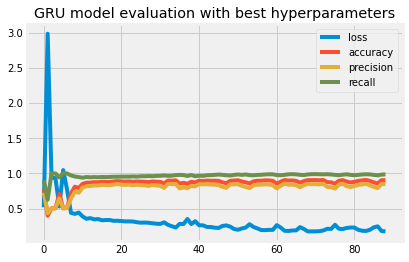

In [120]:
# Plot loss functions
plt.plot(final_GRU_history.history['loss'], label='loss')
plt.plot(final_GRU_history.history['accuracy'], label='accuracy')
plt.plot(final_GRU_history.history['precision'], label='precision')
plt.plot(final_GRU_history.history['recall'], label='recall')
plt.title('GRU model evaluation with best hyperparameters')
plt.legend()
plt.show()

### Evaluate tuned model performance

We now **evaluate the performance of our GRU model run with the best hyperparameters**, and compare both Train and Test accuracy before and after the Bayesian Optimization.

In [121]:
# Evaluate the LSTM model with best parameters
final_GRU_score_train = final_GRU_model.evaluate(g, verbose=0)
final_GRU_score_test = final_GRU_model.evaluate(g_, verbose=0)
print(f'Train Accuracy: {final_GRU_score_train[1]*100:.4}% | Model improvement: {(final_GRU_score_train[1]/GRU_score_train[1]-1)*100:.4}%')
print(f'Test Accuracy: {final_GRU_score_test[1]*100:.4}% | Model improvement: {(final_GRU_score_test[1]/GRU_score_test[1]-1)*100:.4}%')

Train Accuracy: 89.3% | Model improvement: -5.836%
Test Accuracy: 75.94% | Model improvement: 3.217%


**Bayesian Optimization resulted in a much better GRU model** for two main reasons:
- The model is less prone to overfitting and generalizes better, as train accuracy decreased while test accuracy increased.
- Test accuracy improved by 3%. A performance accuracy in out-of-sample prediction of 76% is a good accuracy score.

In [122]:
# LSTM lassification report with best parameters
final_y_pred_GRU = np.where(final_GRU_model.predict(g_, verbose=False) > 0.5, 1, 0)
print(classification_report(y_test[sequence_length:], final_y_pred_GRU))

              precision    recall  f1-score   support

           0       0.99      0.73      0.84       452
           1       0.31      0.96      0.46        55

    accuracy                           0.76       507
   macro avg       0.65      0.85      0.65       507
weighted avg       0.92      0.76      0.80       507



The confusion matrix validates that our GRU model with the optimal set of hyperparameters performs well, as **true predictions largely exceed false predictions**.

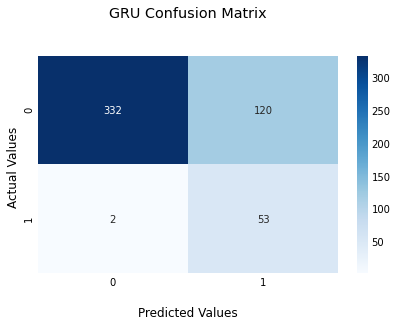

In [123]:
# Plot confusion matrix
final_cf_matrix_GRU = confusion_matrix(y_test[sequence_length:], final_y_pred_GRU)
ax = sn.heatmap(final_cf_matrix_GRU, annot=True, cmap='Blues', fmt='g')
ax.set_title('GRU Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])
plt.show()

Finally, **the ROC curve confirms that our GRU model is able to distinguish between the two classes**, as the AUC score reaches 85%.

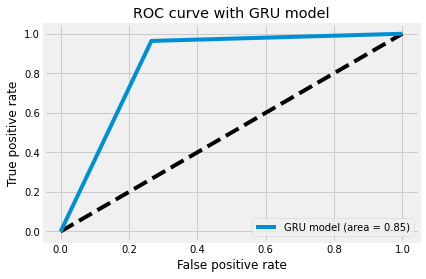

In [139]:
# Plot ROC curve
fpr_final_GRU, tpr_final_GRU, thresholds_final_GRU = roc_curve(y_test[sequence_length:], final_y_pred_GRU)
final_auc_GRU = auc(fpr_final_GRU, tpr_final_GRU)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_final_GRU, tpr_final_GRU, label='GRU model (area = {:.2f})'.format(final_auc_GRU))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve with GRU model')
plt.legend(loc='best')
plt.show()

### Model backtest

As a final step, we visualize our GRU model predictions of the SP500 RV-IV spread on the next trading day against observed realized and implied volatility.

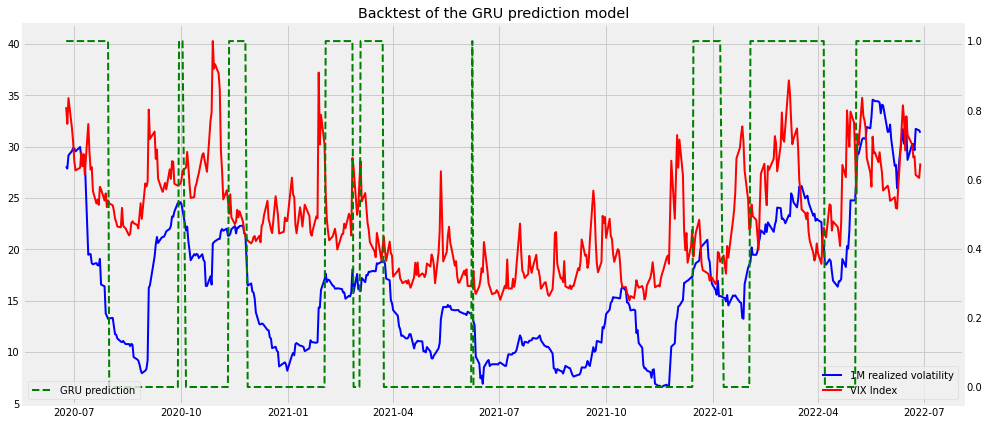

In [125]:
# Resume main variables of interest in a dataframe
df_ = y_test[sequence_length:]
GRU_predicted = pd.DataFrame(final_y_pred_GRU, index=df_.index)
GRU_predicted.columns = ['Predicted']
GRU_strategy = pd.concat([df[['Adj Close','Return','Label','Volatility_21d','VIX']], GRU_predicted], axis=1).dropna()
# Model backtest
fig, ax1 = plt.subplots(figsize=(15,7));
ax2 = ax1.twinx()
ax1.plot(GRU_strategy.index,GRU_strategy['Volatility_21d']*100*(252)**0.5, 'b-', linewidth=2,label='1M realized volatility')
ax1.plot(GRU_strategy.index,GRU_strategy['VIX'], 'r-',linewidth=2,label = 'VIX Index')
ax1.legend(loc='lower right')
ax2.plot(GRU_strategy.index, GRU_strategy['Predicted'], 'g--', linewidth=2, label = 'GRU prediction')
ax2.grid(False)
ax2.legend(loc='lower left');
plt.title('Backtest of the GRU prediction model');

We note that **observed and predicted volatility spread signal are most of the time consistent!**
- Our GRU prediction model correctly predicts all instances where the realized volatility is above the implied volatility.
- Although our GRU model is sometimes wrong in predicting a positive RV-IV spread, we note that the model was close from being right, as wrong predictions were driven by a sharp increase in realized volatility which brought it close - but still below, the implied volatility.

## Conclusion: LSTM vs GRU

In this notebook, we built two RNNs aside, one LSTM and one GRU, in order to compare their performance in a classification problem. Both models were built on the same set-up, that is:
- Stacked structure of 3 layers between an input layer and an output layer
- Dropout regularization for the model to generalize better after the first 2 hidden layers
- Adam optimizer
- Binary Cross Entropy loss function as we deal with a classification problem

For both models, we ran a Bayesian Optimization in order to find the respective best hyperparameters for each model. As main observations, we note:

1. **In-sample and out-of-sample accuracy are very good for both models**: 
    - LSTM: respectively 92% and 80%
    - GRU: respectively 89% and 76%

Both models roughly equally overfit as their accuracies are similar, and so is the spread between train and test accuracy.


2. **Both models beat the baseline model by far. Also, GRU predicts better the class of interest (class 1, positive RV-IV spread) than LSTM, however to the detriment of the other class (class 0, negative RV-IV spread)**:
    - Baseline: 244 true predictions (TN: 219, TP: 25) and 263 false predictions (FN: 30, FP: 233)
    - LSTM: 408 true predictions (TN: 372, TP: 36) and 99 false predictions (FN: 19, FP: 80)
    - GRU: 385 true predictions (TN: 332, TP: 53) and 122 false predictions (FN: 2, FP: 120)


3. **GRU model distinguishes better between the two classes than LSTM and baseline models**
    - baseline ROC auc: 50%
    - LSTM ROC auc: 74%
    - GRU ROC auc: 85%


4. **GRU is faster to converge than LSTM**
    - GRU needs 20 epochs to converge while LSTM requires 100 epochs - 5 times more!
    - GRU is also faster, as hyper parameter tuning process takes 12 minutes, against 15 minutes for LSTM

For all the 4 reasons cited above, we can conclude that, **for this classification prediction exercise, the GRU model performs better than the LSTM model**

# Part III: Support to Investment Management

## Investment management strategy

As final step, we build an investment strategy based on our LSTM and GRU volatility prediction models.

As we have seen, **most of the time, implied volatility is greater than realized volatility**, which results in a negative RV-IV spread over time, and means that the market over-estimates the volatility yet to come. Realized volatility tends to be above the implied volatility in times of market stress, as the market incorporates a large amount of news in reaction to recent events. More particularly, **a positive RV-IV spread indicates a bear market territory as a result of increased volatility.** 

As a consequence, our investment strategy is as follows: **Go long when the model predicts a negative RV-IV spread, go cash when the model predicts a positive RV-IV spread**

### LSTM prediction model

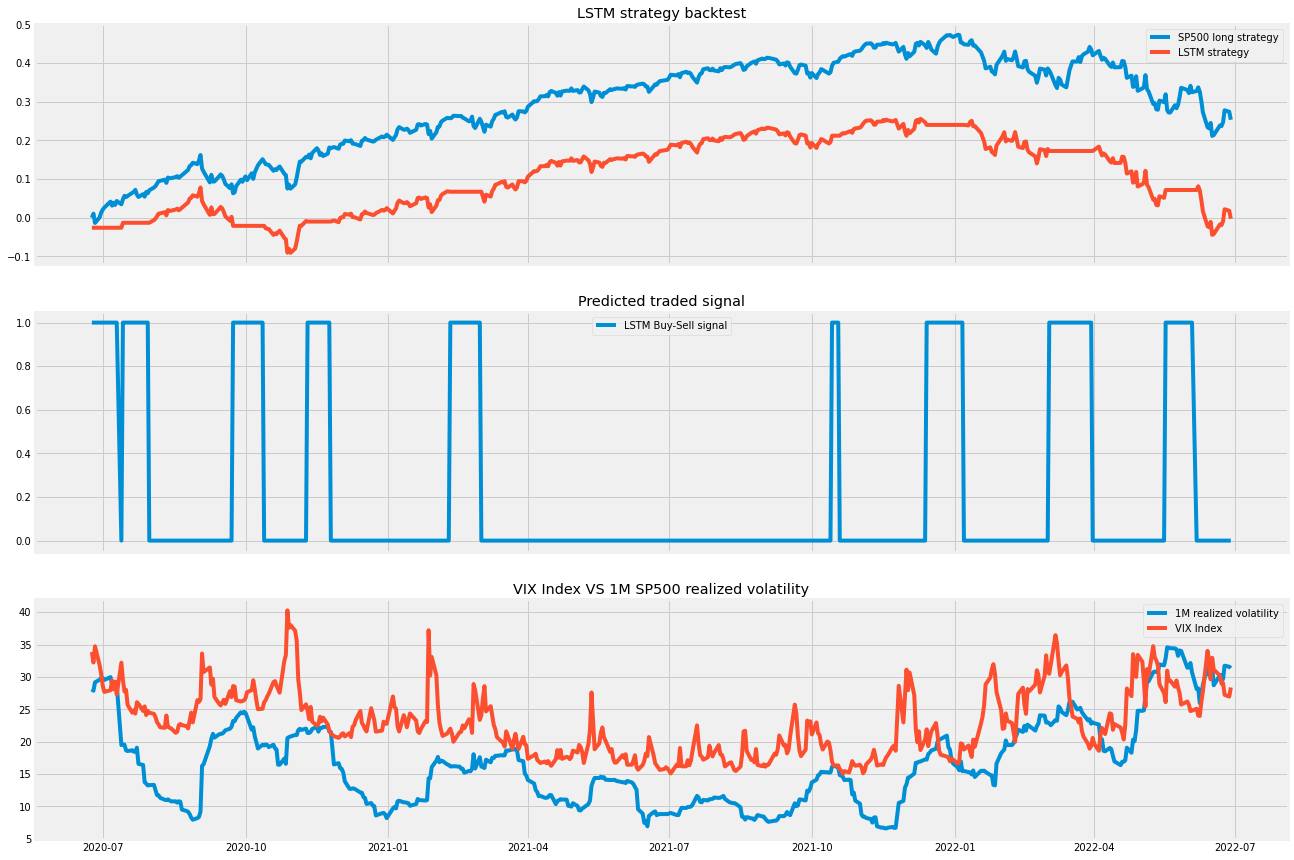

In [142]:
# Resume main variables of interest in a dataframe
df_ = y_test[sequence_length:]
LSTM_predicted = pd.DataFrame(final_y_pred_LSTM, index=df_.index)
LSTM_predicted.columns = ['Predicted']
LSTM_strategy = pd.concat([df[['Adj Close','Return','Label','Volatility_21d','VIX']], LSTM_predicted], axis=1).dropna()
y_LSTM_test = LSTM_strategy['Label'].values
y_LSTM_pred = LSTM_strategy['Predicted'].values
# Calculate the strategy returns
LSTM_strategy['Strategy'] = LSTM_strategy['Return'] * (1-LSTM_strategy['Predicted'].shift(1).fillna(0))
# Calculate the cumulative stock return over the test period - Long buy and hold strategy
LSTM_strategy['Cumulative Return'] = LSTM_strategy['Return'].cumsum() - LSTM_strategy['Return'].iloc[0]
# Calculate the cumulative return of our LSTM classification predicitve strategy
LSTM_strategy['PnL Strategy'] = LSTM_strategy['Strategy'].cumsum()
# Plot strategy
fig, axs = plt.subplots(3, sharex=True, figsize=(20,15));
#fig.suptitle('LSTM Strategy backtesting', size=18);
axs[0].plot(LSTM_strategy.index,LSTM_strategy['Cumulative Return'], label='SP500 long strategy');
axs[0].plot(LSTM_strategy.index,LSTM_strategy['PnL Strategy'], label = 'LSTM strategy');
axs[0].set_title('LSTM strategy backtest')
axs[0].legend();
axs[1].plot(LSTM_strategy.index, y_LSTM_pred, label = 'LSTM Buy-Sell signal');
axs[1].set_title('Predicted traded signal')
axs[1].legend();
axs[2].plot(LSTM_strategy.index,LSTM_strategy['Volatility_21d']*100*(252)**0.5, label='1M realized volatility');
axs[2].plot(LSTM_strategy.index,LSTM_strategy['VIX'], label = 'VIX Index');
axs[2].set_title('VIX Index VS 1M SP500 realized volatility')
axs[2].legend();

### GRU prediction model

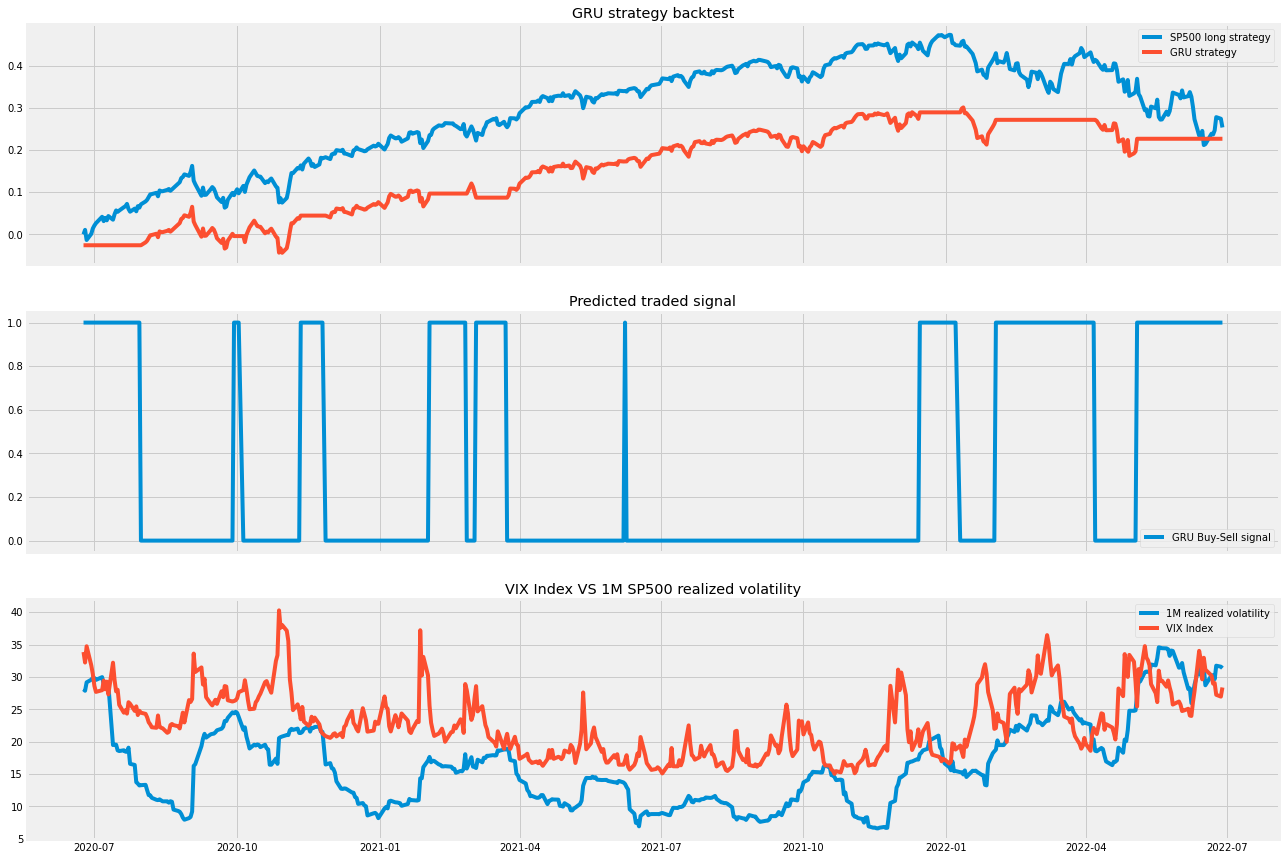

In [132]:
# Resume main variables of interest in a dataframe
df_ = y_test[sequence_length:]
GRU_predicted = pd.DataFrame(final_y_pred_GRU, index=df_.index)
GRU_predicted.columns = ['Predicted']
GRU_strategy = pd.concat([df[['Adj Close','Return','Label','Volatility_21d','VIX']], GRU_predicted], axis=1).dropna()
#y_GRU_test = LSTM_strategy['Label'].values
#y_GRU_pred = LSTM_strategy['Predicted'].values
# Calculate the strategy returns
GRU_strategy['Strategy'] = GRU_strategy['Return'] * (1-GRU_strategy['Predicted'].shift(1).fillna(0))
# Calculate the cumulative stock return over the test period - Long buy and hold strategy
GRU_strategy['Cumulative Return'] = GRU_strategy['Return'].cumsum() - GRU_strategy['Return'].iloc[0]
# Calculate the cumulative return of our GRU classification predicitve strategy
GRU_strategy['PnL Strategy'] = GRU_strategy['Strategy'].cumsum()
# Plot strategy
fig, axs = plt.subplots(3, sharex=True, figsize=(20,15));
#fig.suptitle('LSTM Strategy backtesting', size=18);
axs[0].plot(GRU_strategy.index,GRU_strategy['Cumulative Return'], label='SP500 long strategy');
axs[0].plot(GRU_strategy.index,GRU_strategy['PnL Strategy'], label = 'GRU strategy');
axs[0].set_title('GRU strategy backtest')
axs[0].legend();
axs[1].plot(GRU_strategy.index, GRU_strategy['Predicted'], label = 'GRU Buy-Sell signal');
axs[1].set_title('Predicted traded signal')
axs[1].legend();
axs[2].plot(GRU_strategy.index,GRU_strategy['Volatility_21d']*100*(252)**0.5, label='1M realized volatility');
axs[2].plot(GRU_strategy.index,GRU_strategy['VIX'], label = 'VIX Index');
axs[2].set_title('VIX Index VS 1M SP500 realized volatility')
axs[2].legend();

Shame for us - we end up testing our investment strategy on right after the post Covid-19 period, where the SP500 Index strongly recovered and signed among its strongest performance ever. 

- From July 2020 to December 2021, even bad Covid-19 related news such as lock-downs, resulted in stock rise because of Quantiative Easing and weak policy from major Central Banks. Therefore, **over this period, getting out of the market simply resulted in missed performance, as FOMO was too important**, which explains why our investment strategy and our two model do not perform well in such situation.
- From January 2022 until June 2022, as a result of rising inflation, war in Ukraine and supply-chain disruptions due to Covid-19 strong recovery, the economy and financial markets went back to their fundamentals. **In this period, the GRU model performs particularly well, by going cash when the market dropped**.

In summary, most of the time, the return of the GRU strategy was below the SP500 long strategy return up until June 2022 where they converged to similar values. **It appears that the GRU stratey does well in identifying the bear market and avoiding losses while it initially struggled a little identifying the bull market after the Covid-19 shock**.